In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from scipy.ndimage import rotate
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

class RotatedMNISTDataset(Dataset):
    def __init__(self, num_samples=1000, digit=4):
        super().__init__()
        # Load MNIST dataset
        mnist = datasets.MNIST('./data', train=True, download=True,
                             transform=transforms.ToTensor())
        
        # Find all indices of the desired digit
        digit_indices = (mnist.targets == digit).nonzero().squeeze()
        
        # Take the first instance of the digit
        self.original_image = mnist.data[digit_indices[0]].float() / 255.0
        
        self.num_samples = num_samples
        self.angles = np.linspace(0, 360, num_samples, endpoint=False)
        
        # Pre-compute all rotated images
        self.rotated_images = []
        for angle in self.angles:
            # Rotate image using scipy's rotate with bilinear interpolation
            rotated = rotate(self.original_image.numpy(), angle, reshape=False, order=1, mode='constant', cval=0.0)
            self.rotated_images.append(torch.tensor(rotated, dtype=torch.float32))

            
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        angle = self.angles[idx]
        # Normalize angle to [-1, 1] range instead of [0, 1]
        normalized_angle = (angle / 180.0) - 1.0
        return (torch.tensor([normalized_angle], dtype=torch.float32), 
                self.rotated_images[idx].unsqueeze(0).float())

class CNNDecoderWithActivations(nn.Module):
    def __init__(self, input_size=1, hidden_size=64):
        super().__init__()
        
        # Initial fully connected layer to create feature volume
        self.fc = nn.Linear(input_size, 7 * 7 * hidden_size)
        
        # Convolutional decoder
        self.decoder = nn.Sequential(
            # 7x7 -> 14x14
            nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(True),
            
            # 14x14 -> 28x28
            nn.ConvTranspose2d(hidden_size, hidden_size//2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_size//2),
            nn.ReLU(True),
            
            # Final convolution to get single channel
            nn.Conv2d(hidden_size//2, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Convert angle to initial feature volume
        x = self.fc(x)
        x = x.view(x.size(0), -1, 7, 7)  # Reshape to [batch_size, channels, 7, 7]
        # Apply convolutional decoder
        x = self.decoder(x)
        return x

def train_rotation_model(
    model,
    train_dataset,
    val_split=0.1,
    batch_size=32,
    num_epochs=100,
    learning_rate=1e-3,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_best=True,
    visualization_interval=10
):
    """
    Training loop with combined MSE and perceptual loss
    """
    print(f"Training on device: {device}")
    model = model.to(device)
    
    # Split dataset into train and validation
    val_size = int(len(train_dataset) * val_split)
    train_size = len(train_dataset) - val_size
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    # Loss function - combination of MSE and L1
    criterion = lambda output, target: F.mse_loss(output, target) + 0.1 * F.l1_loss(output, target)
    
    # Optimizer with gradient clipping
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                                    patience=5, verbose=True, min_lr=1e-6)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    # Create fixed angles for visualization
    fixed_angles = torch.linspace(-1, 1, 8).to(device)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for angles, targets in train_loader:
            angles, targets = angles.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(angles)
            loss = criterion(outputs, targets)
            
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for angles, targets in val_loader:
                angles, targets = angles.to(device), targets.to(device)
                outputs = model(angles)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {avg_train_loss:.6f}')
        print(f'Validation Loss: {avg_val_loss:.6f}')
        
        # Visualization
        if (epoch + 1) % visualization_interval == 0:
            model.eval()
            with torch.no_grad():
                test_outputs = model(fixed_angles.unsqueeze(1))
                
                plt.figure(figsize=(15, 4))
                for i in range(8):
                    plt.subplot(1, 8, i+1)
                    plt.imshow(test_outputs[i, 0].cpu().detach().numpy(), cmap='gray')
                    angle_deg = (fixed_angles[i].item() + 1) * 180
                    plt.title(f'{angle_deg:.1f}°')
                    plt.axis('off')
                plt.tight_layout()
                plt.show()
                
                # Plot loss curves
                plt.figure(figsize=(10, 5))
                plt.plot(train_losses, label='Training Loss')
                plt.plot(val_losses, label='Validation Loss')
                plt.title('Training and Validation Losses')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.yscale('log')
                plt.grid(True)
                plt.show()
        
        # Save best model
        if save_best and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
            }, 'best_rotation_model.pth')
    
    return train_losses, val_losses

# Function to load and test the best model
def load_and_test_model(model, path='best_rotation_model.pth', device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Load the best model and generate a sequence of rotated images
    """
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Generate a sequence of rotations
    angles = torch.linspace(0, 1, 16).to(device)  # 16 angles from 0 to 360 degrees
    
    with torch.no_grad():
        outputs = model(angles.unsqueeze(1))
        
        # Create animation grid
        img_grid = make_grid(outputs, nrow=8, normalize=True)
        plt.figure(figsize=(15, 8))
        plt.imshow(img_grid.cpu().permute(1, 2, 0).detach().numpy(), cmap='gray')
        plt.title('Generated Rotations\n' + ' '.join([f"{ang*360:.1f}°" for ang in angles]))
        plt.axis('off')
        plt.show()

2024-12-25 04:12:03,987 - INFO - Using device: cuda
2024-12-25 04:12:04,421 - INFO - Created dataset with 1000 samples
2024-12-25 04:12:04,449 - INFO - Model architecture:
CNNDecoderWithActivations(
  (fc): Linear(in_features=1, out_features=6272, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)
2024-12-25 04:12:04,450 - INFO - Total parameters: 406,913
2024-12-25 04:12:04,451 - INFO - Trainable parameters: 406,913


Training on device: cuda
Epoch [1/300]
Training Loss: 0.206691
Validation Loss: 0.118466
Epoch [2/300]
Training Loss: 0.088089
Validation Loss: 0.072354
Epoch [3/300]
Training Loss: 0.065748
Validation Loss: 0.063901
Epoch [4/300]
Training Loss: 0.061392
Validation Loss: 0.061489
Epoch [5/300]
Training Loss: 0.059047
Validation Loss: 0.058832
Epoch [6/300]
Training Loss: 0.055378
Validation Loss: 0.055206
Epoch [7/300]
Training Loss: 0.051586
Validation Loss: 0.049002
Epoch [8/300]
Training Loss: 0.048430
Validation Loss: 0.044832
Epoch [9/300]
Training Loss: 0.045241
Validation Loss: 0.041393
Epoch [10/300]
Training Loss: 0.045259
Validation Loss: 0.039214
Epoch [11/300]
Training Loss: 0.041801
Validation Loss: 0.037400


Epoch [12/300]
Training Loss: 0.042061
Validation Loss: 0.035794
Epoch [13/300]
Training Loss: 0.041415
Validation Loss: 0.035253
Epoch [14/300]
Training Loss: 0.040669
Validation Loss: 0.033789
Epoch [15/300]
Training Loss: 0.040684
Validation Loss: 0.034422
Epoch [16/300]
Training Loss: 0.039208
Validation Loss: 0.031747
Epoch [17/300]
Training Loss: 0.037701
Validation Loss: 0.030088
Epoch [18/300]
Training Loss: 0.036847
Validation Loss: 0.030873
Epoch [19/300]
Training Loss: 0.037860
Validation Loss: 0.029862
Epoch [20/300]
Training Loss: 0.037467
Validation Loss: 0.031001
Epoch [21/300]
Training Loss: 0.034000
Validation Loss: 0.028579
Epoch [22/300]
Training Loss: 0.036394
Validation Loss: 0.031034
Epoch [23/300]
Training Loss: 0.034523
Validation Loss: 0.027721
Epoch [24/300]
Training Loss: 0.033045
Validation Loss: 0.026758
Epoch [25/300]
Training Loss: 0.032605
Validation Loss: 0.025449
Epoch [26/300]
Training Loss: 0.031328
Validation Loss: 0.025207
Epoch [27/300]
Training L

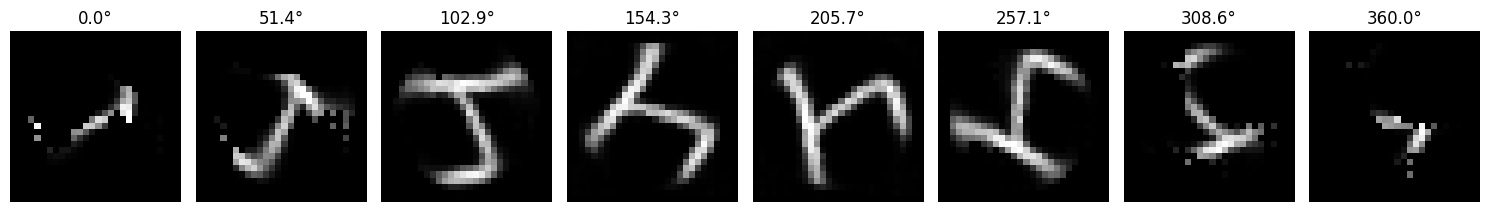

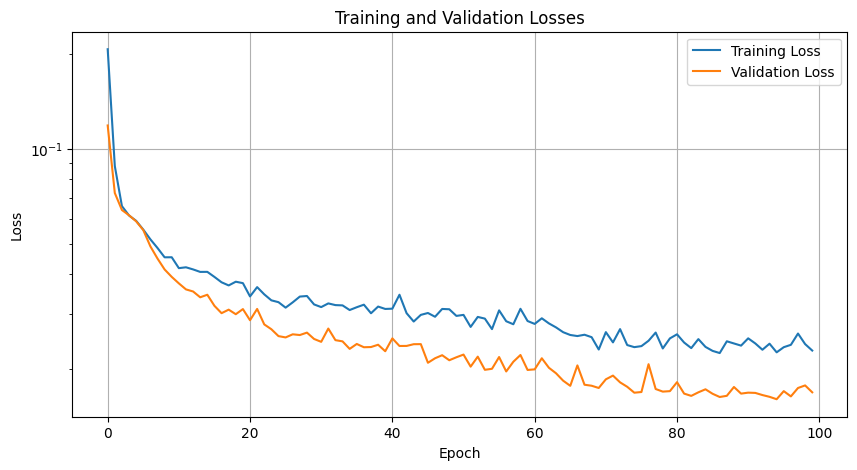

Epoch [101/300]
Training Loss: 0.022870
Validation Loss: 0.016551
Epoch [102/300]
Training Loss: 0.024159
Validation Loss: 0.016554
Epoch [103/300]
Training Loss: 0.021899
Validation Loss: 0.015869
Epoch [104/300]
Training Loss: 0.022756
Validation Loss: 0.017206
Epoch [105/300]
Training Loss: 0.022515
Validation Loss: 0.016210
Epoch [106/300]
Training Loss: 0.024019
Validation Loss: 0.016482
Epoch [107/300]
Training Loss: 0.024951
Validation Loss: 0.016744
Epoch [108/300]
Training Loss: 0.022693
Validation Loss: 0.015889
Epoch [109/300]
Training Loss: 0.022142
Validation Loss: 0.015966
Epoch [110/300]
Training Loss: 0.022131
Validation Loss: 0.016577
Epoch [111/300]
Training Loss: 0.021744
Validation Loss: 0.015860
Epoch [112/300]
Training Loss: 0.024439
Validation Loss: 0.017149
Epoch [113/300]
Training Loss: 0.022046
Validation Loss: 0.016236
Epoch [114/300]
Training Loss: 0.022272
Validation Loss: 0.015836
Epoch [115/300]
Training Loss: 0.022652
Validation Loss: 0.015861
Epoch [116

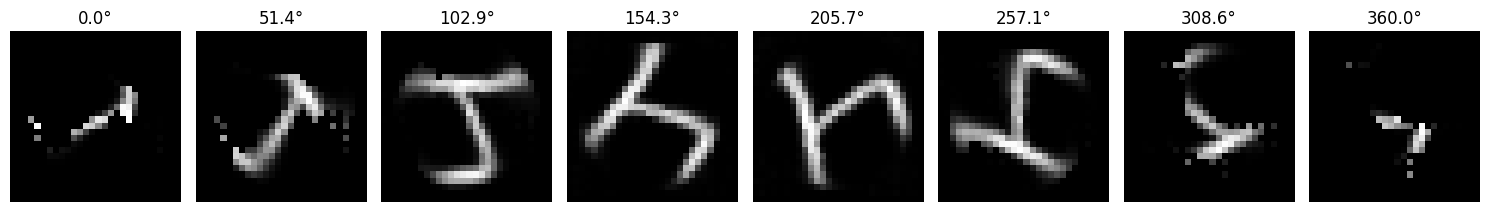

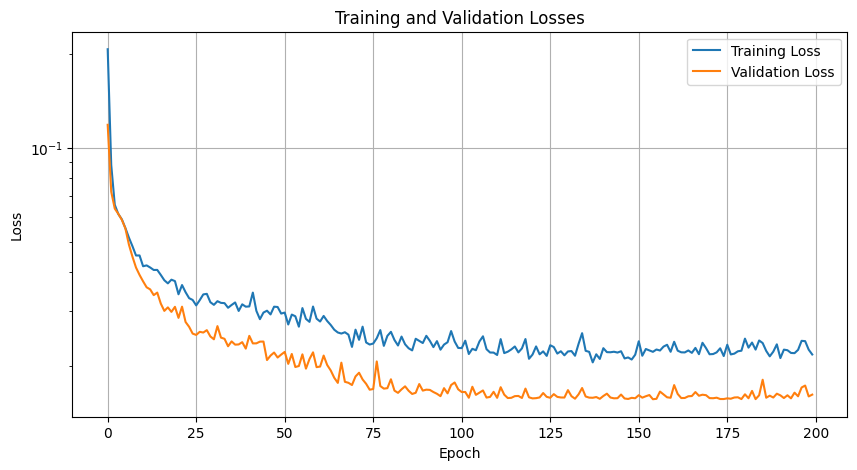

Epoch [201/300]
Training Loss: 0.022393
Validation Loss: 0.015819
Epoch [202/300]
Training Loss: 0.022913
Validation Loss: 0.015827
Epoch [203/300]
Training Loss: 0.022094
Validation Loss: 0.015787
Epoch [204/300]
Training Loss: 0.021461
Validation Loss: 0.015764
Epoch [205/300]
Training Loss: 0.023427
Validation Loss: 0.016124
Epoch [206/300]
Training Loss: 0.023516
Validation Loss: 0.016584
Epoch [207/300]
Training Loss: 0.021591
Validation Loss: 0.015797
Epoch [208/300]
Training Loss: 0.023288
Validation Loss: 0.016755
Epoch [209/300]
Training Loss: 0.023032
Validation Loss: 0.015800
Epoch [210/300]
Training Loss: 0.023022
Validation Loss: 0.016701
Epoch [211/300]
Training Loss: 0.022397
Validation Loss: 0.015808
Epoch [212/300]
Training Loss: 0.022182
Validation Loss: 0.015789
Epoch [213/300]
Training Loss: 0.021944
Validation Loss: 0.016107
Epoch [214/300]
Training Loss: 0.023195
Validation Loss: 0.015749
Epoch [215/300]
Training Loss: 0.022170
Validation Loss: 0.016137
Epoch [216

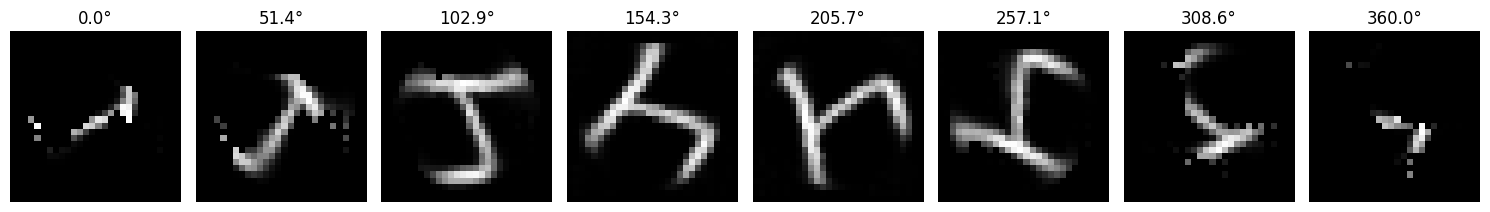

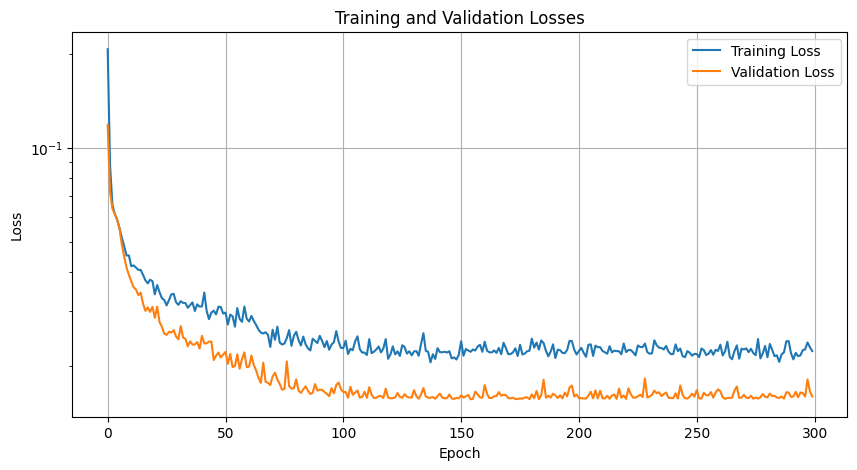

2024-12-25 04:14:50,187 - INFO - Training completed. Generating final visualizations...
/tmp/ipykernel_3649260/263118948.py:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


ValueError: object __array__ method not producing an array

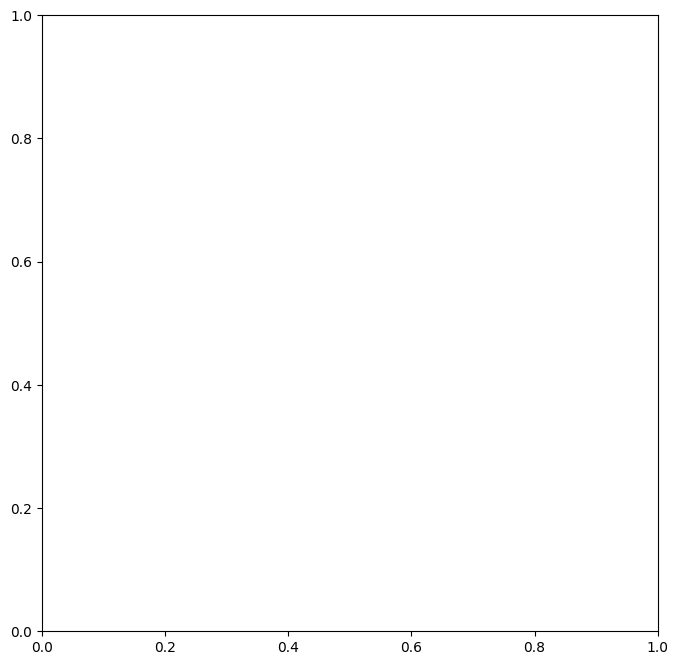

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import logging
import random
import os

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def set_seed(seed=42):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def setup_training(config):
    """Setup training environment and return necessary components"""
    # Create output directory
    Path(config['output_dir']).mkdir(parents=True, exist_ok=True)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f'Using device: {device}')
    
    # Create dataset
    dataset = RotatedMNISTDataset(
        num_samples=config['num_samples'],
        digit=config['digit']
    )
    logging.info(f'Created dataset with {len(dataset)} samples')
    
    # Initialize model
    model = CNNDecoderWithActivations(
        input_size=config['input_size'],
        hidden_size=config['hidden_size']
    ).to(device)
    
    logging.info(f'Model architecture:\n{model}')
    
    # Calculate total parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    logging.info(f'Total parameters: {total_params:,}')
    logging.info(f'Trainable parameters: {trainable_params:,}')
    
    return device, dataset, model

def main():
    # Configuration
    config = {
        # Model parameters
        'input_size': 1,
        'hidden_size': 128,  # Adjusted to match new architecture
        
        # Dataset parameters
        'num_samples': 1000,
        'digit': 4,
        'batch_size': 32,
        
        # Training parameters
        'num_epochs': 300,
        'learning_rate': 1e-3,
        'val_split': 0.1,
        'seed': 42,
        
        # Training setup
        'output_dir': './data/11_15_rot_mnist',
        'visualization_interval': 100,
        'save_best': True
    }
    
    # Set random seed for reproducibility
    set_seed(config['seed'])
    
    # Setup training environment
    device, dataset, model = setup_training(config)
    
    # Train model
    try:
        train_losses, val_losses = train_rotation_model(
            model=model,
            train_dataset=dataset,
            val_split=config['val_split'],
            batch_size=config['batch_size'],
            num_epochs=config['num_epochs'],
            learning_rate=config['learning_rate'],
            device=device,
            save_best=config['save_best'],
            visualization_interval=config['visualization_interval']
        )
        
        # Save final model and training results
        final_checkpoint_path = os.path.join(config['output_dir'], 'final_model.pth')
        torch.save({
            'model_state_dict': model.state_dict(),
            'config': config,
            'train_losses': train_losses,
            'val_losses': val_losses
        }, final_checkpoint_path)
        
        # Final visualization
        logging.info('Training completed. Generating final visualizations...')
        load_and_test_model(model, os.path.join(config['output_dir'], 'final_model.pth'), device)
        
        # Plot final loss curves
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Final Training and Validation Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.yscale('log')
        plt.grid(True)
        plt.savefig(os.path.join(config['output_dir'], 'loss_curves.png'))
        plt.close()
        
    except KeyboardInterrupt:
        logging.info('Training interrupted by user. Saving current model state...')
        torch.save({
            'model_state_dict': model.state_dict(),
            'config': config,
            'train_losses': train_losses,
            'val_losses': val_losses
        }, os.path.join(config['output_dir'], 'interrupted_model.pth'))
        
    except Exception as e:
        logging.error(f'Error during training: {str(e)}')
        raise

if __name__ == '__main__':
    main()

# Radian input

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from scipy.ndimage import rotate
import matplotlib.pyplot as plt

class RotatedMNISTDataset(Dataset):
    def __init__(self, num_samples=1000, digit=4):
        super().__init__()
        # Load MNIST dataset
        mnist = datasets.MNIST('./data', train=True, download=True,
                             transform=transforms.ToTensor())
        
        # Find all indices of the desired digit
        digit_indices = (mnist.targets == digit).nonzero().squeeze()
        
        # Take the first instance of the digit
        self.original_image = mnist.data[digit_indices[0]].float() / 255.0
        
        self.num_samples = num_samples
        # Generate angles in radians
        self.angles = np.linspace(0, 2*np.pi, num_samples, endpoint=False)
        
        # Pre-compute all rotated images
        self.rotated_images = []
        for angle in self.angles:
            # Convert to degrees for scipy rotate
            angle_deg = angle * 180 / np.pi
            # Rotate image using scipy's rotate with bilinear interpolation
            rotated = rotate(self.original_image.numpy(), angle_deg, reshape=False, 
                           order=1, mode='constant', cval=0.0)
            self.rotated_images.append(torch.tensor(rotated))
            
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        angle = self.angles[idx]
        # Convert angle to sine and cosine components
        angle_sin = np.sin(angle)
        angle_cos = np.cos(angle)
        return (torch.tensor([angle_cos, angle_sin], dtype=torch.float32), 
                self.rotated_images[idx].unsqueeze(0).float())

class CNNDecoderWithActivations(nn.Module):
    def __init__(self, input_size=2, hidden_size=64):
        super().__init__()
        
        # Initial fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, 7 * 7 * hidden_size)
        )
        
        # Convolutional decoder
        self.decoder = nn.Sequential(
            # 7x7 -> 14x14
            nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(True),
            
            # 14x14 -> 28x28
            nn.ConvTranspose2d(hidden_size, hidden_size//2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_size//2),
            nn.ReLU(True),
            
            # Final convolutions to refine details
            nn.Conv2d(hidden_size//2, hidden_size//2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_size//2),
            nn.ReLU(True),
            
            nn.Conv2d(hidden_size//2, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Convert angle encoding to initial feature volume
        x = self.fc(x)
        x = x.view(x.size(0), -1, 7, 7)  # Reshape to [batch_size, channels, 7, 7]
        # Apply convolutional decoder
        x = self.decoder(x)
        return x

def visualize_results(model, device, num_samples=8):
    """Visualize results with periodic angles"""
    model.eval()
    with torch.no_grad():
        # Generate angles from 0 to 2π
        angles = torch.linspace(0, 2*np.pi, num_samples, device=device)
        inputs = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1)
        
        outputs = model(inputs)
        
        plt.figure(figsize=(2*num_samples, 4))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow(outputs[i, 0].cpu().detach().numpy(), cmap='gray')
            angle_deg = angles[i].item() * 180 / np.pi
            plt.title(f'{angle_deg:.1f}°')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

def train_rotation_model(
    model,
    train_dataset,
    val_split=0.1,
    batch_size=32,
    num_epochs=100,
    learning_rate=1e-3,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_best=True,
    visualization_interval=10
):
    print(f"Training on device: {device}")
    model = model.to(device)
    
    # Split dataset into train and validation
    val_size = int(len(train_dataset) * val_split)
    train_size = len(train_dataset) - val_size
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    # Loss function - combination of MSE and L1
    criterion = lambda output, target: F.mse_loss(output, target) + 0.1 * F.l1_loss(output, target)
    
    # Optimizer with gradient clipping
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                                    patience=5, verbose=True, min_lr=1e-6)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for angles, targets in train_loader:
            angles, targets = angles.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(angles)
            loss = criterion(outputs, targets)
            
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for angles, targets in val_loader:
                angles, targets = angles.to(device), targets.to(device)
                outputs = model(angles)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {avg_train_loss:.6f}')
        print(f'Validation Loss: {avg_val_loss:.6f}')
        
        # Visualization
        if (epoch + 1) % visualization_interval == 0:
            visualize_results(model, device)
            
            # Plot loss curves
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.title('Training and Validation Losses')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.yscale('log')
            plt.grid(True)
            plt.show()
        
        # Save best model
        if save_best and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
            }, 'best_rotation_model.pth')
    
    return train_losses, val_losses

Training on device: cuda
Epoch [1/100]
Training Loss: 0.070294
Validation Loss: 0.044426
Epoch [2/100]
Training Loss: 0.040804
Validation Loss: 0.039460
Epoch [3/100]
Training Loss: 0.036323
Validation Loss: 0.035517
Epoch [4/100]
Training Loss: 0.033022
Validation Loss: 0.032772
Epoch [5/100]
Training Loss: 0.030114
Validation Loss: 0.030776


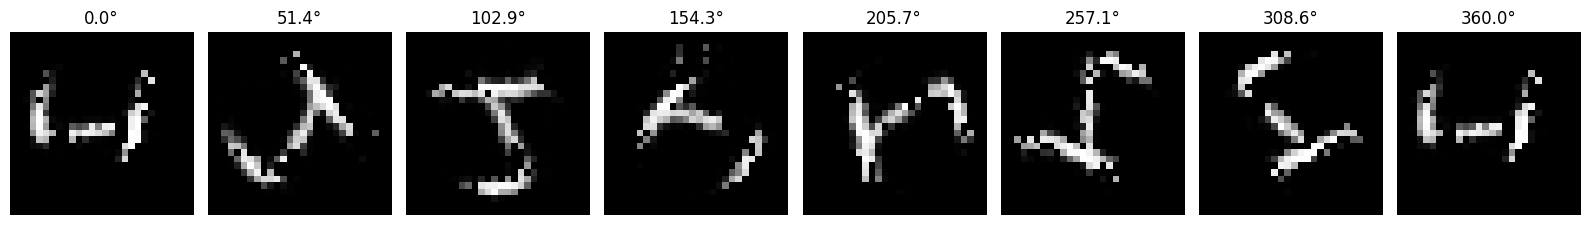

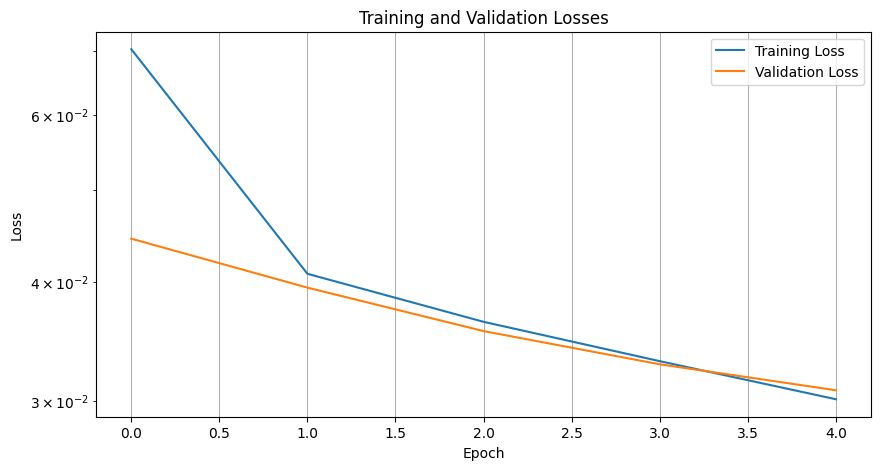

Epoch [6/100]
Training Loss: 0.028194
Validation Loss: 0.028397
Epoch [7/100]
Training Loss: 0.026022
Validation Loss: 0.025624
Epoch [8/100]
Training Loss: 0.023394
Validation Loss: 0.022819
Epoch [9/100]
Training Loss: 0.020537
Validation Loss: 0.020230
Epoch [10/100]
Training Loss: 0.018014
Validation Loss: 0.017772


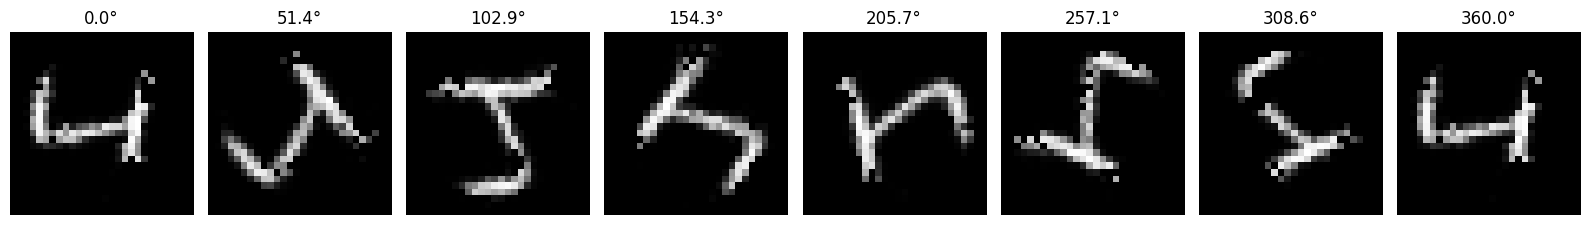

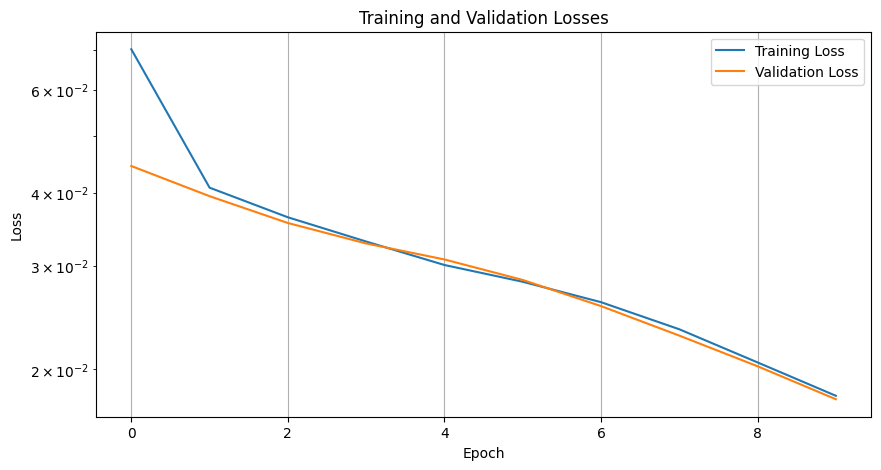

Epoch [11/100]
Training Loss: 0.015900
Validation Loss: 0.016382
Epoch [12/100]
Training Loss: 0.014303
Validation Loss: 0.014860
Epoch [13/100]
Training Loss: 0.012509
Validation Loss: 0.013233
Epoch [14/100]
Training Loss: 0.011026
Validation Loss: 0.011711
Epoch [15/100]
Training Loss: 0.009902
Validation Loss: 0.010502


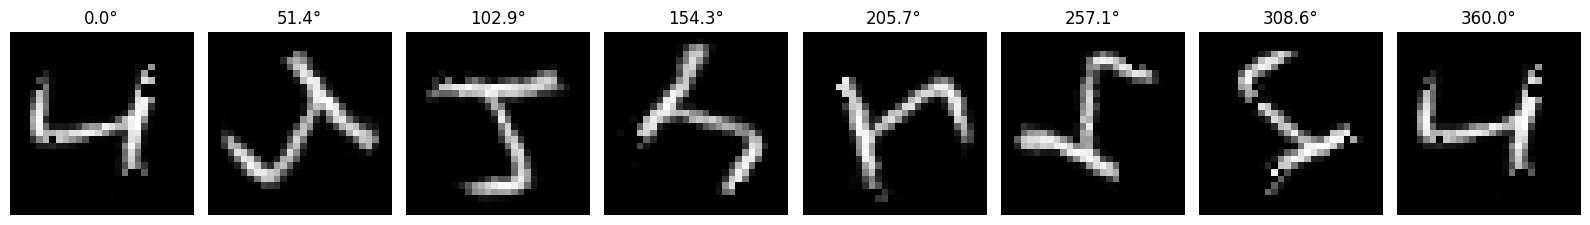

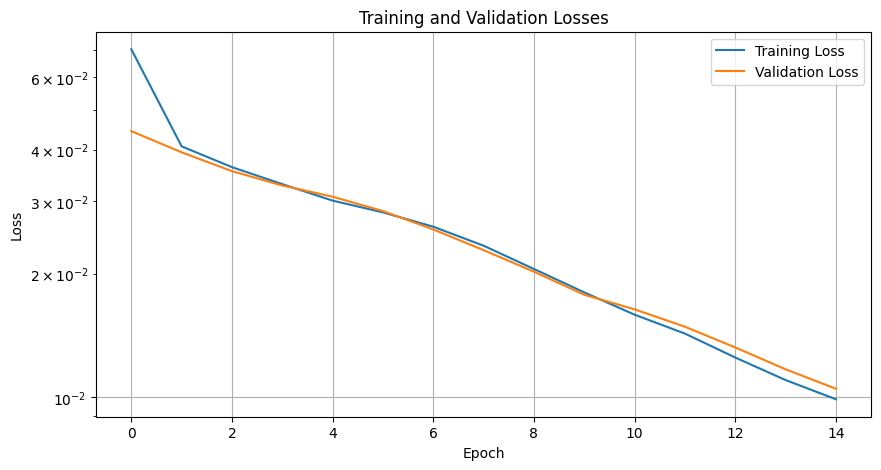

Epoch [16/100]
Training Loss: 0.008544
Validation Loss: 0.008177
Epoch [17/100]
Training Loss: 0.007030
Validation Loss: 0.006978
Epoch [18/100]
Training Loss: 0.006006
Validation Loss: 0.005636
Epoch [19/100]
Training Loss: 0.005071
Validation Loss: 0.004829
Epoch [20/100]
Training Loss: 0.004576
Validation Loss: 0.004441


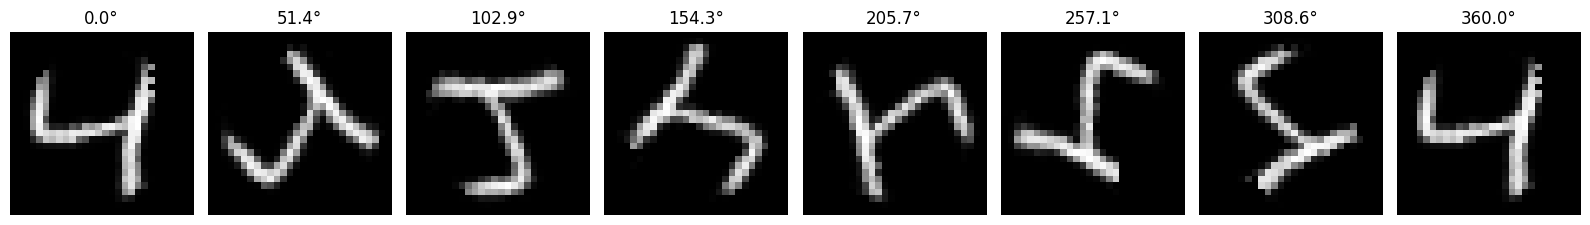

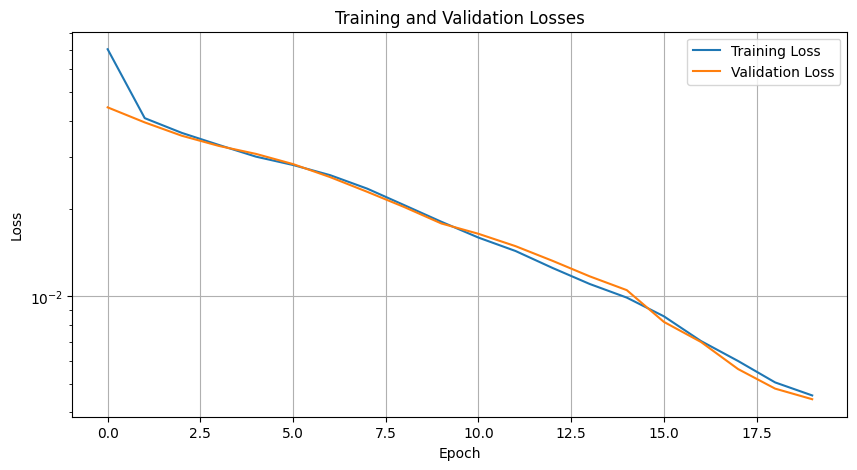

Epoch [21/100]
Training Loss: 0.004212
Validation Loss: 0.004302
Epoch [22/100]
Training Loss: 0.004023
Validation Loss: 0.003549
Epoch [23/100]
Training Loss: 0.003637
Validation Loss: 0.003604
Epoch [24/100]
Training Loss: 0.003558
Validation Loss: 0.003267
Epoch [25/100]
Training Loss: 0.003604
Validation Loss: 0.003650


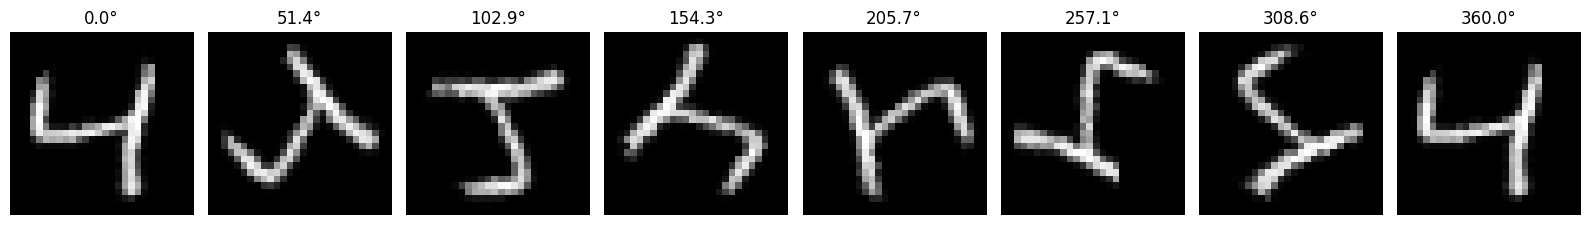

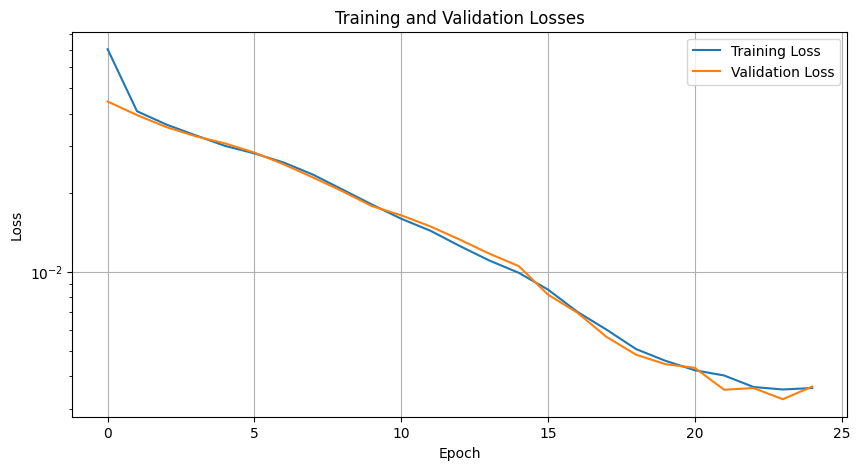

Epoch [26/100]
Training Loss: 0.003442
Validation Loss: 0.003402
Epoch [27/100]
Training Loss: 0.003454
Validation Loss: 0.003738
Epoch [28/100]
Training Loss: 0.003250
Validation Loss: 0.002588
Epoch [29/100]
Training Loss: 0.002641
Validation Loss: 0.002474
Epoch [30/100]
Training Loss: 0.002476
Validation Loss: 0.002262


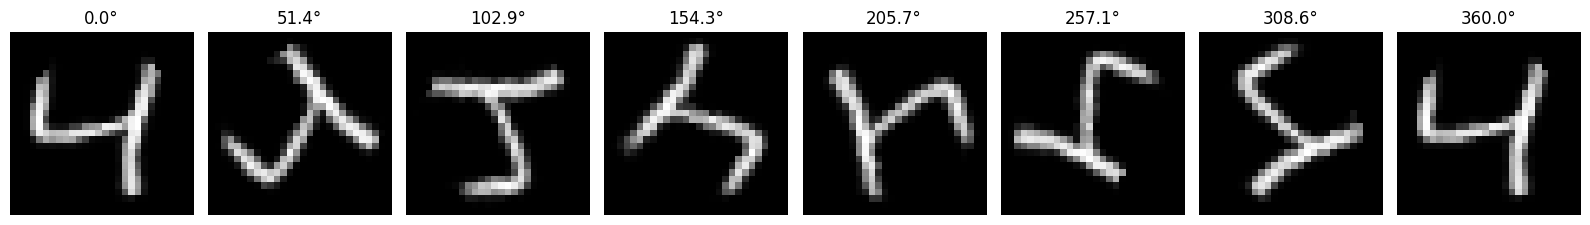

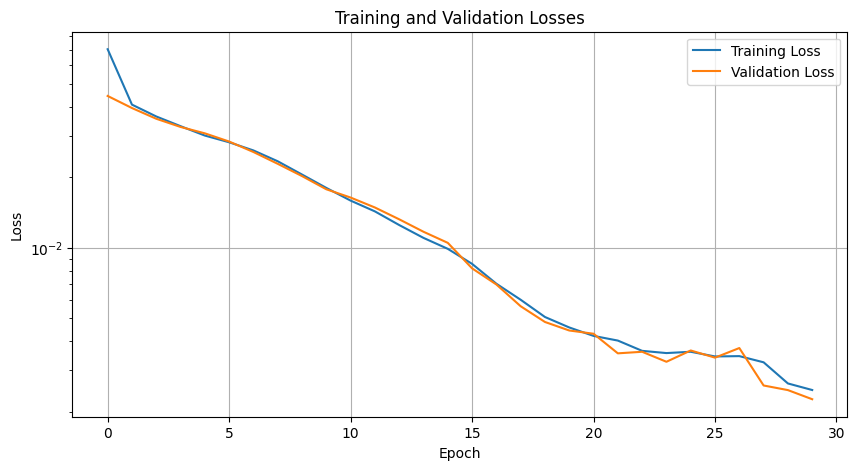

Epoch [31/100]
Training Loss: 0.002390
Validation Loss: 0.002205
Epoch [32/100]
Training Loss: 0.002239
Validation Loss: 0.002065
Epoch [33/100]
Training Loss: 0.002113
Validation Loss: 0.001902
Epoch [34/100]
Training Loss: 0.001948
Validation Loss: 0.001781
Epoch [35/100]
Training Loss: 0.001889
Validation Loss: 0.001806


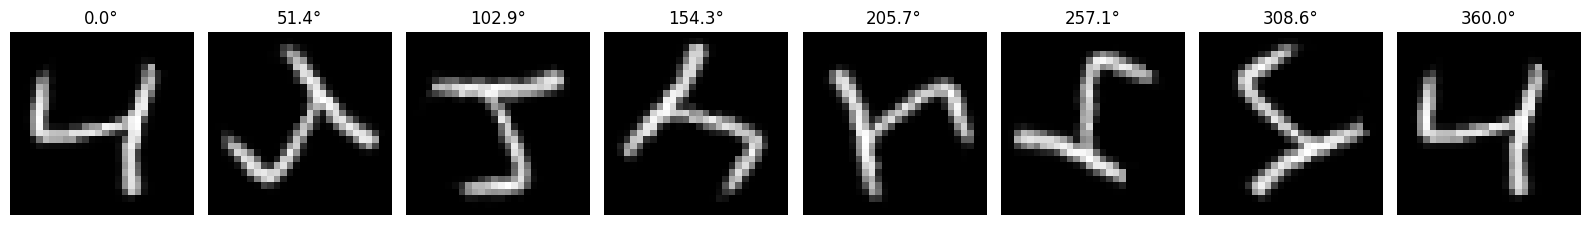

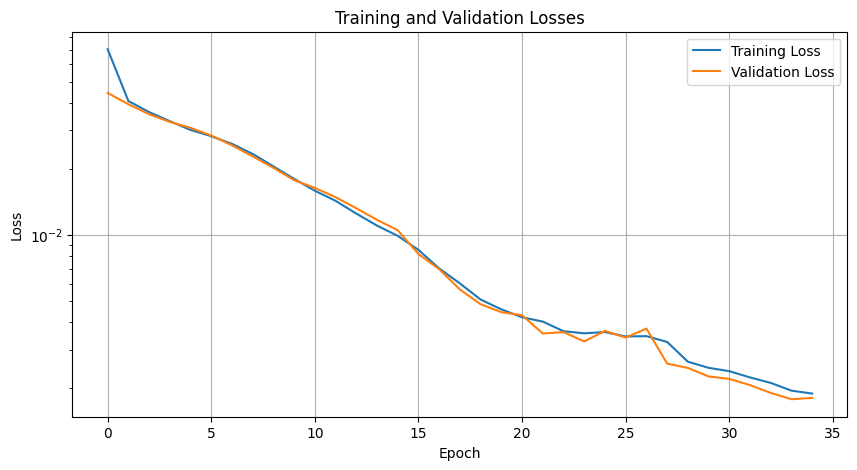

Epoch [36/100]
Training Loss: 0.002006
Validation Loss: 0.001797
Epoch [37/100]
Training Loss: 0.001905
Validation Loss: 0.001760
Epoch [38/100]
Training Loss: 0.001791
Validation Loss: 0.001471
Epoch [39/100]
Training Loss: 0.001663
Validation Loss: 0.001568
Epoch [40/100]
Training Loss: 0.001603
Validation Loss: 0.001544


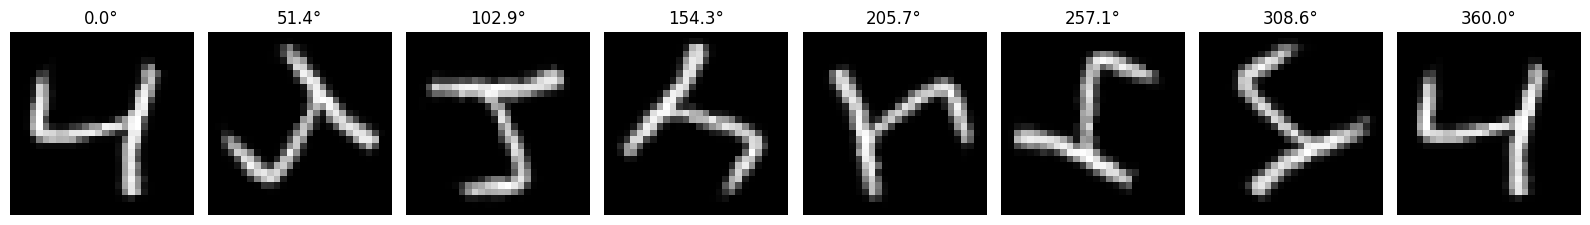

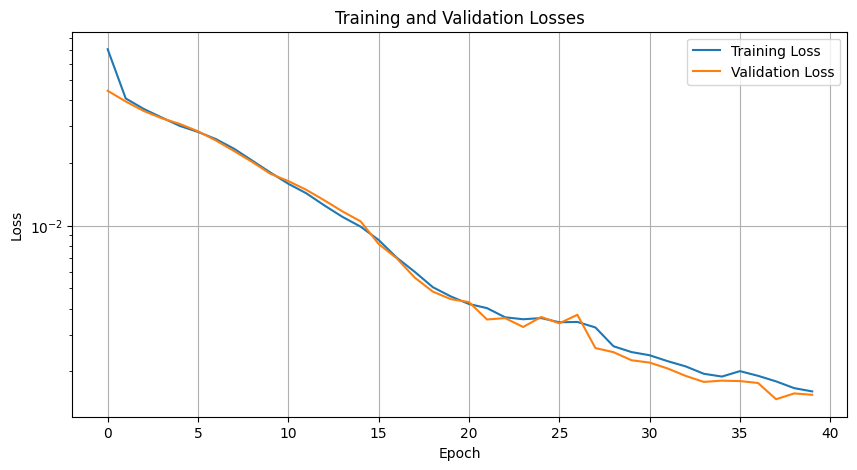

Epoch [41/100]
Training Loss: 0.001603
Validation Loss: 0.001601
Epoch [42/100]
Training Loss: 0.001642
Validation Loss: 0.001601
Epoch [43/100]
Training Loss: 0.001600
Validation Loss: 0.001501
Epoch [44/100]
Training Loss: 0.001637
Validation Loss: 0.001934
Epoch [45/100]
Training Loss: 0.001448
Validation Loss: 0.001206


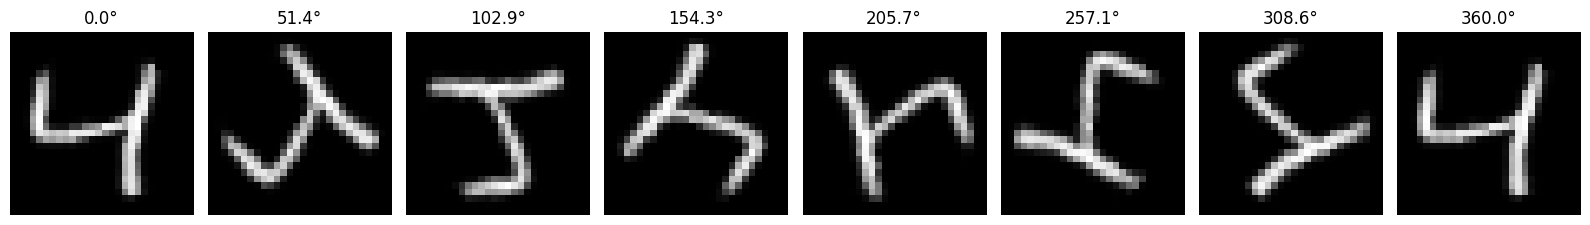

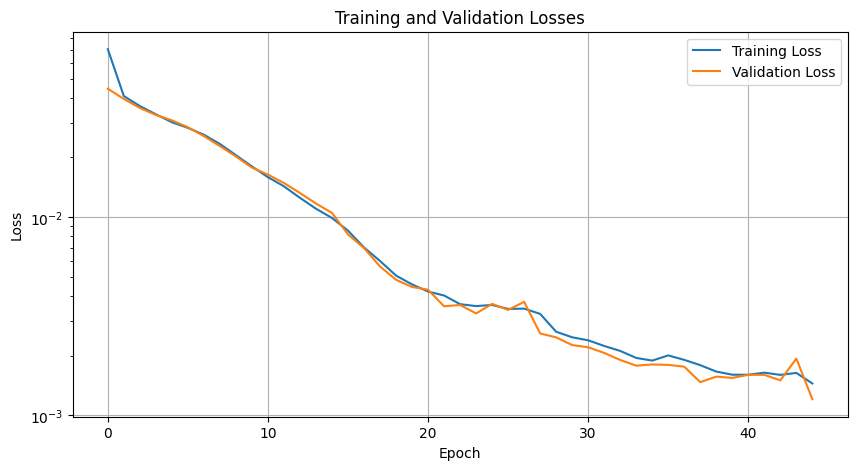

Epoch [46/100]
Training Loss: 0.001146
Validation Loss: 0.001052
Epoch [47/100]
Training Loss: 0.001052
Validation Loss: 0.000962
Epoch [48/100]
Training Loss: 0.001017
Validation Loss: 0.000971
Epoch [49/100]
Training Loss: 0.001019
Validation Loss: 0.000914
Epoch [50/100]
Training Loss: 0.000994
Validation Loss: 0.000916


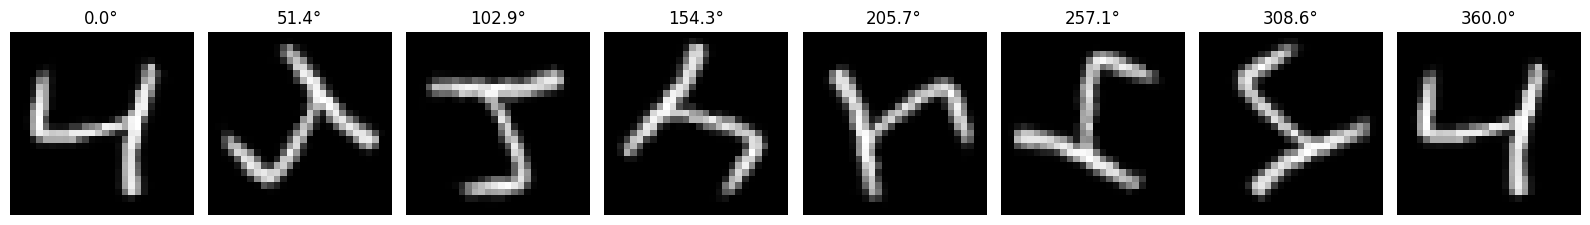

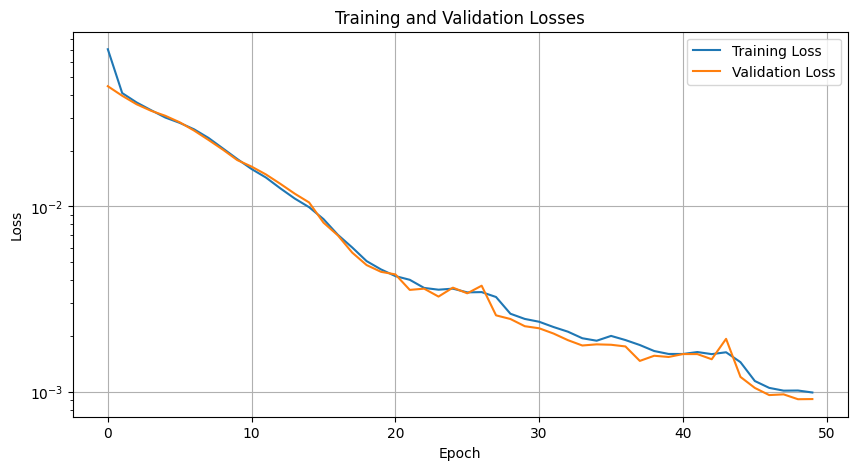

Epoch [51/100]
Training Loss: 0.000984
Validation Loss: 0.000928
Epoch [52/100]
Training Loss: 0.000981
Validation Loss: 0.000896
Epoch [53/100]
Training Loss: 0.000959
Validation Loss: 0.000945
Epoch [54/100]
Training Loss: 0.000987
Validation Loss: 0.000934
Epoch [55/100]
Training Loss: 0.000962
Validation Loss: 0.000901


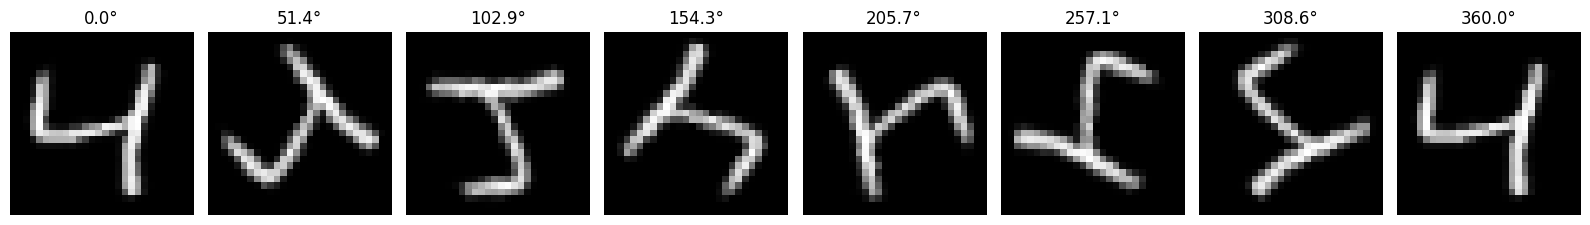

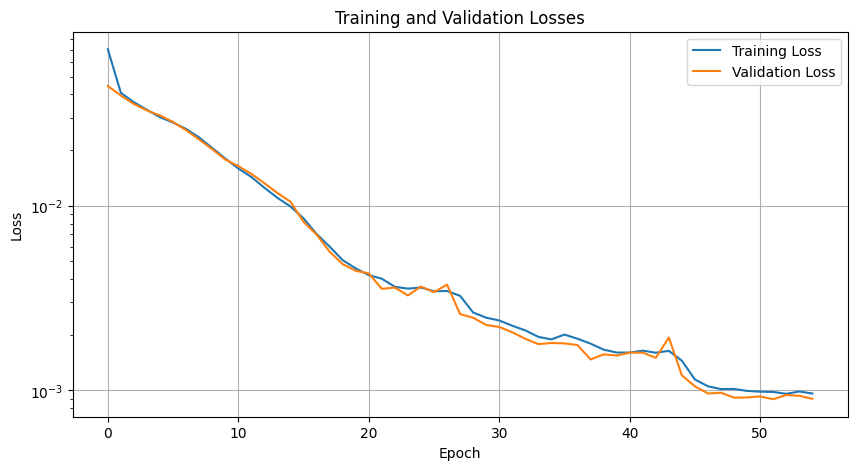

Epoch [56/100]
Training Loss: 0.001015
Validation Loss: 0.000949
Epoch [57/100]
Training Loss: 0.001059
Validation Loss: 0.000947
Epoch [58/100]
Training Loss: 0.000969
Validation Loss: 0.000948
Epoch [59/100]
Training Loss: 0.000870
Validation Loss: 0.000764
Epoch [60/100]
Training Loss: 0.000811
Validation Loss: 0.000789


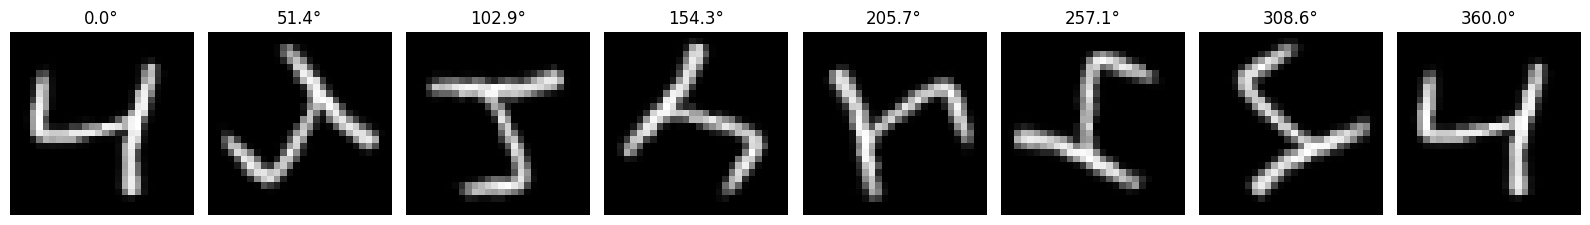

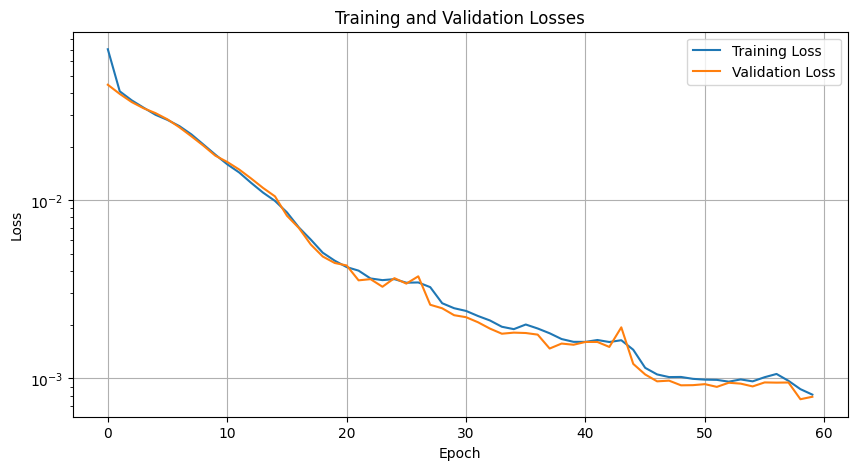

Epoch [61/100]
Training Loss: 0.000786
Validation Loss: 0.000734
Epoch [62/100]
Training Loss: 0.000756
Validation Loss: 0.000727
Epoch [63/100]
Training Loss: 0.000716
Validation Loss: 0.000707
Epoch [64/100]
Training Loss: 0.000709
Validation Loss: 0.000658
Epoch [65/100]
Training Loss: 0.000691
Validation Loss: 0.000688


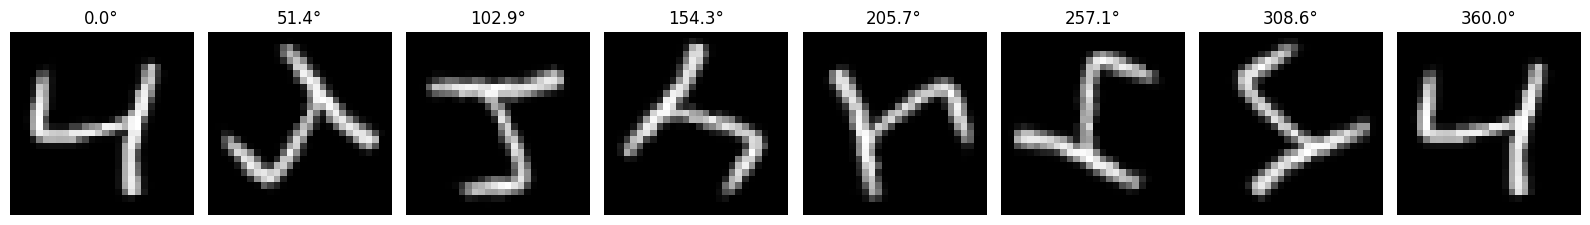

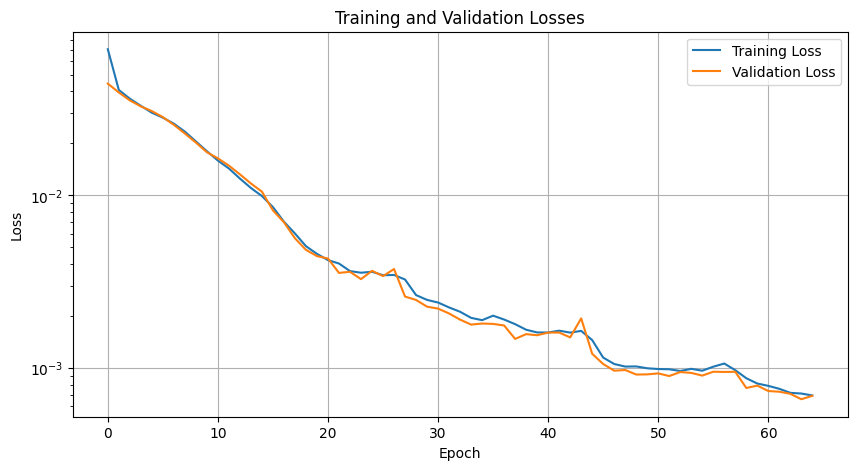

Epoch [66/100]
Training Loss: 0.000669
Validation Loss: 0.000635
Epoch [67/100]
Training Loss: 0.000630
Validation Loss: 0.000613
Epoch [68/100]
Training Loss: 0.000627
Validation Loss: 0.000609
Epoch [69/100]
Training Loss: 0.000626
Validation Loss: 0.000609
Epoch [70/100]
Training Loss: 0.000634
Validation Loss: 0.000672


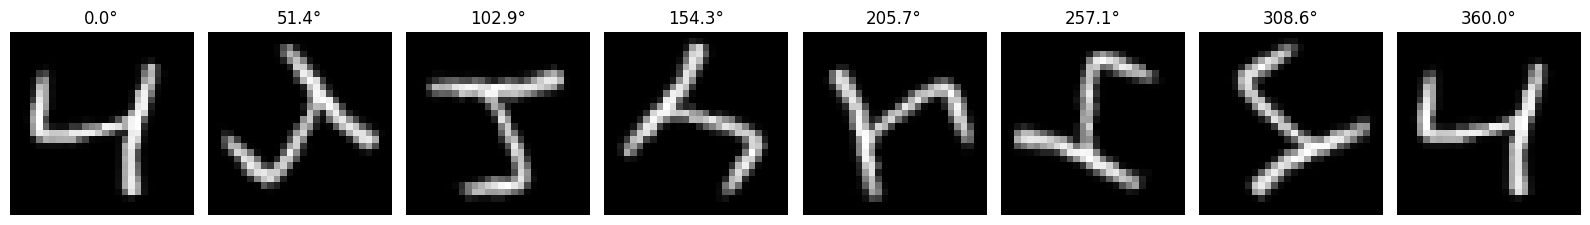

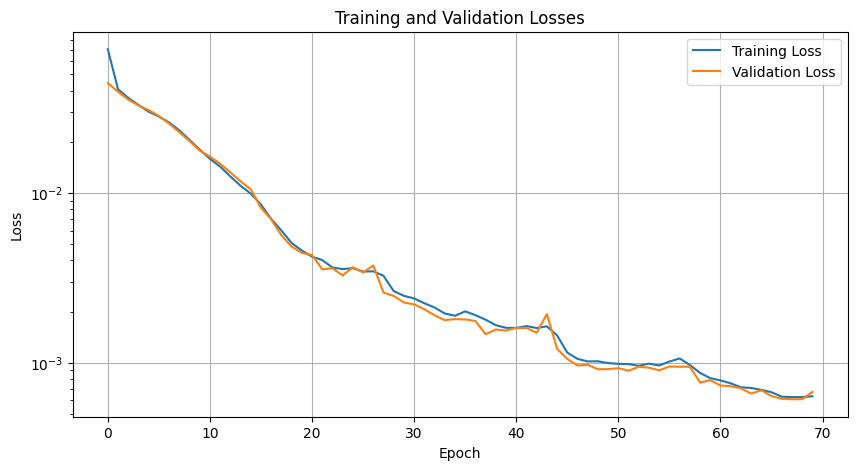

Epoch [71/100]
Training Loss: 0.000660
Validation Loss: 0.000648
Epoch [72/100]
Training Loss: 0.000629
Validation Loss: 0.000613
Epoch [73/100]
Training Loss: 0.000627
Validation Loss: 0.000610
Epoch [74/100]
Training Loss: 0.000631
Validation Loss: 0.000640
Epoch [75/100]
Training Loss: 0.000580
Validation Loss: 0.000552


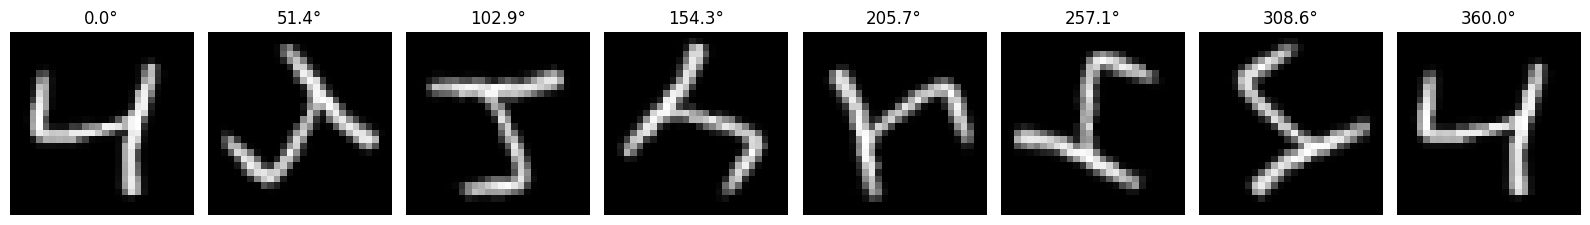

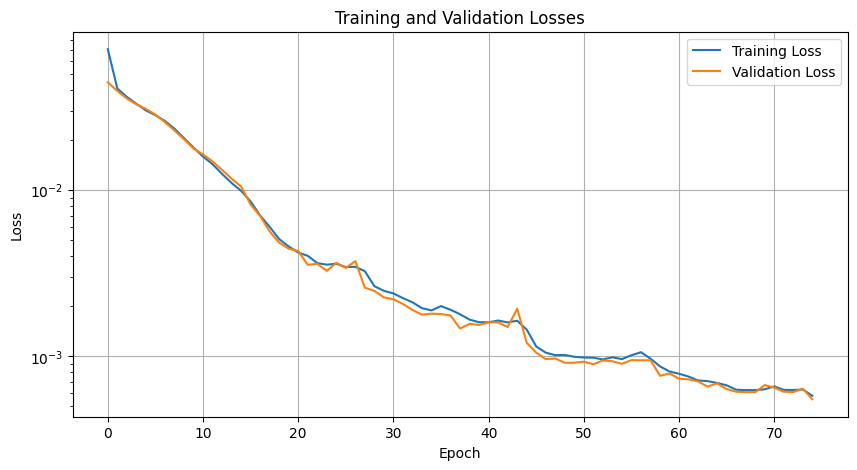

Epoch [76/100]
Training Loss: 0.000547
Validation Loss: 0.000533
Epoch [77/100]
Training Loss: 0.000537
Validation Loss: 0.000537
Epoch [78/100]
Training Loss: 0.000535
Validation Loss: 0.000528
Epoch [79/100]
Training Loss: 0.000543
Validation Loss: 0.000536
Epoch [80/100]
Training Loss: 0.000540
Validation Loss: 0.000540


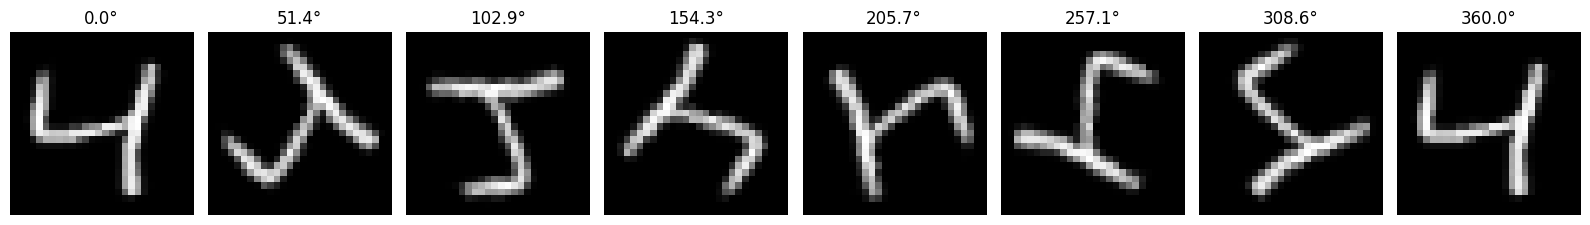

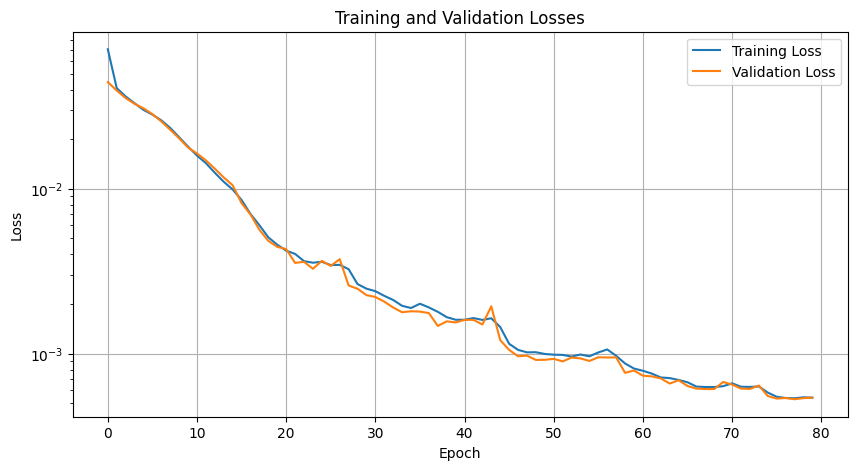

Epoch [81/100]
Training Loss: 0.000535
Validation Loss: 0.000534
Epoch [82/100]
Training Loss: 0.000533
Validation Loss: 0.000536
Epoch [83/100]
Training Loss: 0.000533
Validation Loss: 0.000521
Epoch [84/100]
Training Loss: 0.000531
Validation Loss: 0.000539
Epoch [85/100]
Training Loss: 0.000530
Validation Loss: 0.000518


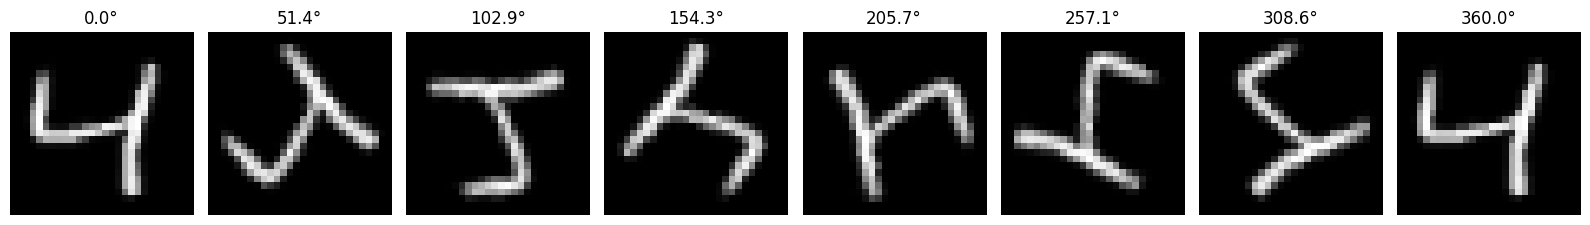

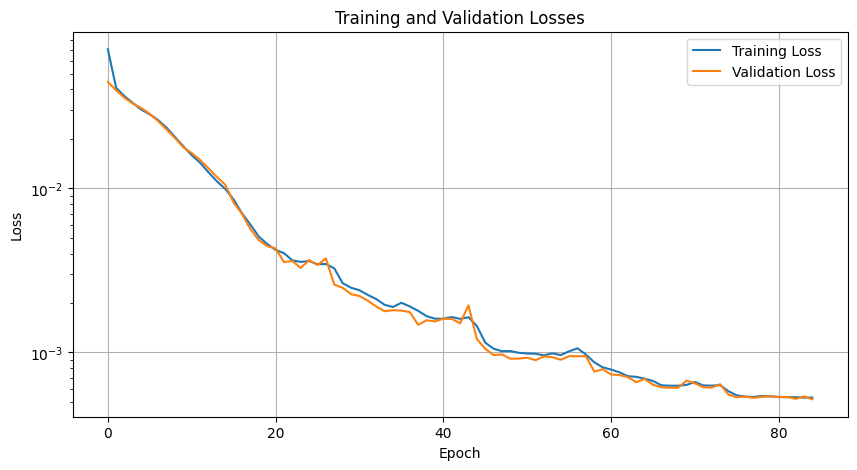

Epoch [86/100]
Training Loss: 0.000533
Validation Loss: 0.000540
Epoch [87/100]
Training Loss: 0.000532
Validation Loss: 0.000522
Epoch [88/100]
Training Loss: 0.000542
Validation Loss: 0.000529
Epoch [89/100]
Training Loss: 0.000527
Validation Loss: 0.000522
Epoch [90/100]
Training Loss: 0.000535
Validation Loss: 0.000525


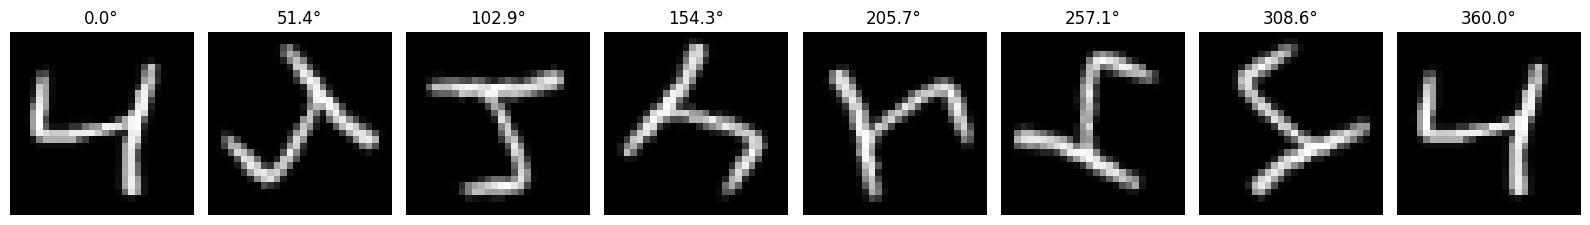

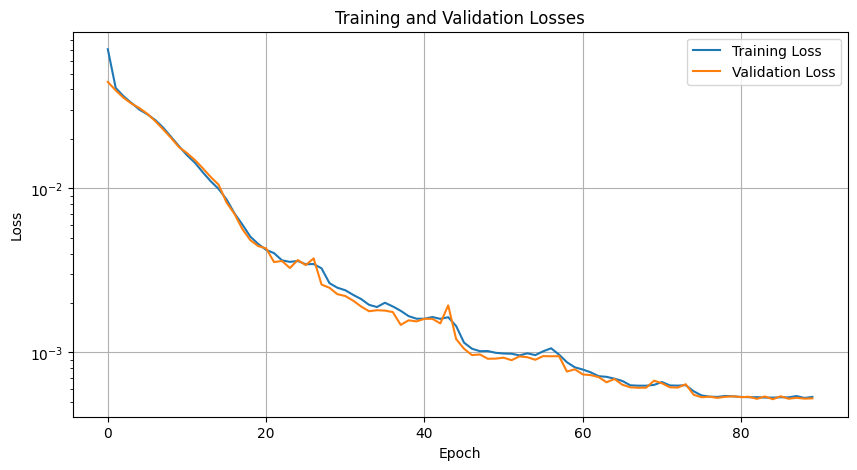

Epoch [91/100]
Training Loss: 0.000531
Validation Loss: 0.000521
Epoch [92/100]
Training Loss: 0.000503
Validation Loss: 0.000490
Epoch [93/100]
Training Loss: 0.000488
Validation Loss: 0.000484
Epoch [94/100]
Training Loss: 0.000488
Validation Loss: 0.000483
Epoch [95/100]
Training Loss: 0.000486
Validation Loss: 0.000484


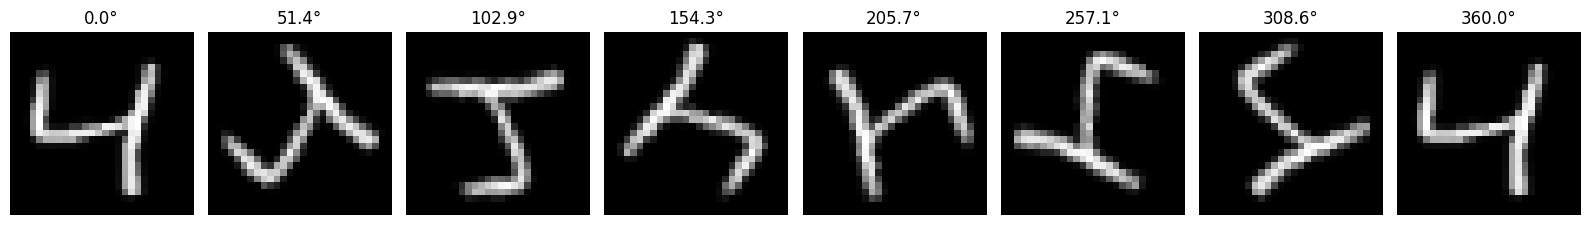

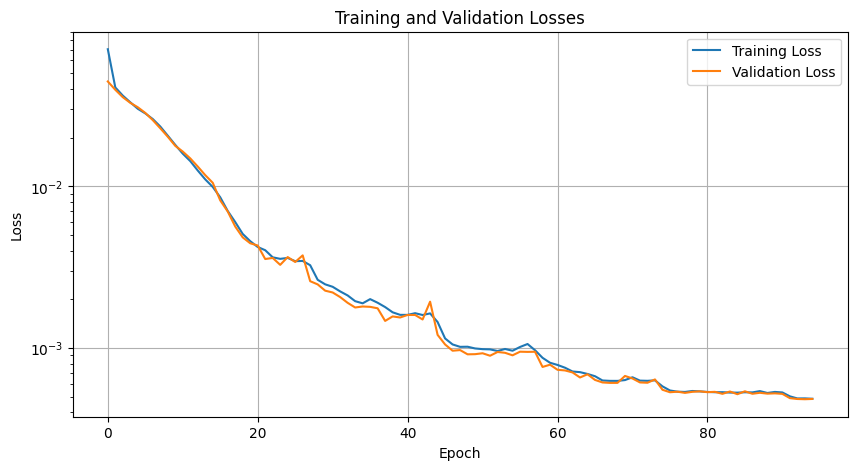

Epoch [96/100]
Training Loss: 0.000487
Validation Loss: 0.000483
Epoch [97/100]
Training Loss: 0.000489
Validation Loss: 0.000494
Epoch [98/100]
Training Loss: 0.000491
Validation Loss: 0.000488
Epoch [99/100]
Training Loss: 0.000488
Validation Loss: 0.000486
Epoch [100/100]
Training Loss: 0.000482
Validation Loss: 0.000485


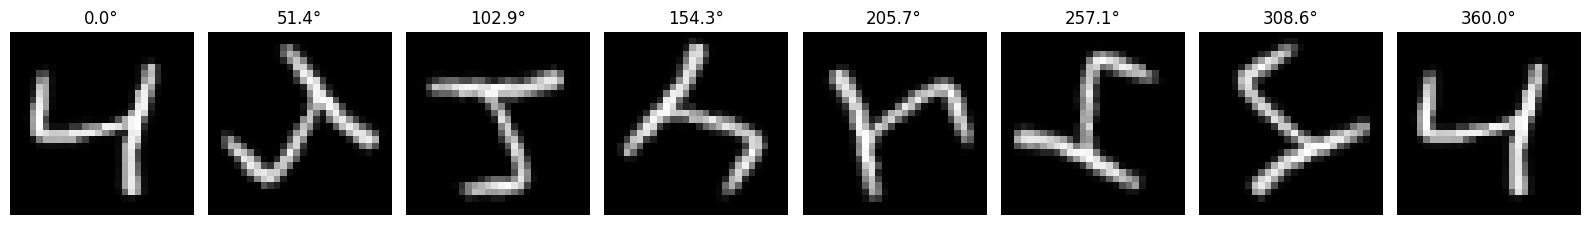

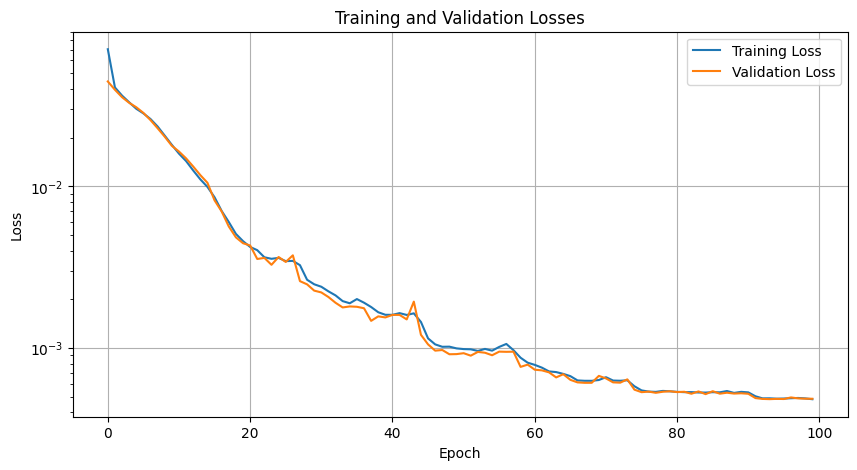

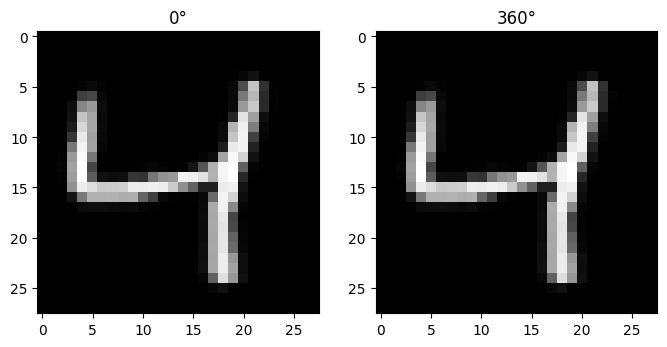

In [12]:
# Set up the model and dataset
dataset = RotatedMNISTDataset(num_samples=1000, digit=4)
model = CNNDecoderWithActivations(input_size=2, hidden_size=128)

# Training parameters
batch_size = 32
num_epochs = 100
learning_rate = 1e-3

# Train the model
train_losses, val_losses = train_rotation_model(
    model=model,
    train_dataset=dataset,
    batch_size=batch_size,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    visualization_interval=5
)

# Test periodic behavior
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()
with torch.no_grad():
    # Test 0° and 360°
    angle_0 = torch.tensor([[1.0, 0.0]], device=device)  # cos(0), sin(0)
    angle_360 = torch.tensor([[1.0, 0.0]], device=device)  # cos(2π), sin(2π)
    
    output_0 = model(angle_0)
    output_360 = model(angle_360)
    
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.imshow(output_0[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.title('0°')
    plt.subplot(122)
    plt.imshow(output_360[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.title('360°')
    plt.show()

# Held-out

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from scipy.ndimage import rotate
import matplotlib.pyplot as plt

class CNNDecoderWithActivations(nn.Module):
    def __init__(self, input_size=1, hidden_size=64):
        super().__init__()
        
        # Initial fully connected layer to create feature volume
        self.fc = nn.Linear(input_size, 7 * 7 * hidden_size)
        
        # Convolutional decoder
        self.decoder = nn.Sequential(
            # 7x7 -> 14x14
            nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(True),
            
            # 14x14 -> 28x28
            nn.ConvTranspose2d(hidden_size, hidden_size//2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_size//2),
            nn.ReLU(True),
            
            # Final convolution to get single channel
            nn.Conv2d(hidden_size//2, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Convert angle to initial feature volume
        x = self.fc(x)
        x = x.view(x.size(0), -1, 7, 7)  # Reshape to [batch_size, channels, 7, 7]
        # Apply convolutional decoder
        x = self.decoder(x)
        return x

def train_rotation_model(
    model,
    train_dataset,
    val_split=0.1,
    batch_size=32,
    num_epochs=100,
    learning_rate=1e-3,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_best=True,
    visualization_interval=10
):
    print(f"Training on device: {device}")
    model = model.to(device)
    
    # Split dataset into train and validation
    val_size = int(len(train_dataset) * val_split)
    train_size = len(train_dataset) - val_size
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    # Loss function - combination of MSE and L1
    criterion = lambda output, target: F.mse_loss(output, target) + 0.1 * F.l1_loss(output, target)
    
    # Optimizer with gradient clipping
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                                    patience=5, verbose=True, min_lr=1e-6)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for angles, targets in train_loader:
            angles, targets = angles.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(angles)
            loss = criterion(outputs, targets)
            
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for angles, targets in val_loader:
                angles, targets = angles.to(device), targets.to(device)
                outputs = model(angles)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {avg_train_loss:.6f}')
        print(f'Validation Loss: {avg_val_loss:.6f}')
        
        # Visualization
        if (epoch + 1) % visualization_interval == 0:
            visualize_results(model, device)
            
            # Plot loss curves
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.title('Training and Validation Losses')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.yscale('log')
            plt.grid(True)
            plt.show()
        
        # Save best model
        if save_best and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
            }, 'best_rotation_model.pth')
    
    return train_losses, val_losses

# Function to load and test the best model
def load_and_test_model(model, path='best_rotation_model.pth', device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Load the best model and generate a sequence of rotated images
    """
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Generate a sequence of rotations
    angles = torch.linspace(0, 1, 16).to(device)  # 16 angles from 0 to 360 degrees
    
    with torch.no_grad():
        outputs = model(angles.unsqueeze(1))
        
        # Create animation grid
        img_grid = make_grid(outputs, nrow=8, normalize=True)
        plt.figure(figsize=(15, 8))
        plt.imshow(img_grid.cpu().permute(1, 2, 0).detach().numpy(), cmap='gray')
        plt.title('Generated Rotations\n' + ' '.join([f"{ang*360:.1f}°" for ang in angles]))
        plt.axis('off')
        plt.show()

class RotatedMNISTDataset(Dataset):
    def __init__(self, num_samples=1000, digit=4, gap_start=160, gap_end=200):
        super().__init__()
        # Load MNIST dataset
        mnist = datasets.MNIST('./data', train=True, download=True,
                             transform=transforms.ToTensor())
        
        # Find all indices of the desired digit
        digit_indices = (mnist.targets == digit).nonzero().squeeze()
        
        # Take the first instance of the digit
        self.original_image = mnist.data[digit_indices[0]].float() / 255.0
        
        # Convert gap angles to radians
        gap_start_rad = gap_start * np.pi / 180
        gap_end_rad = gap_end * np.pi / 180
        
        # Create two sets of angles: before and after the gap
        angles_before = np.linspace(0, gap_start_rad, int(num_samples * gap_start/360), endpoint=False)
        angles_after = np.linspace(gap_end_rad, 2*np.pi, int(num_samples * (360-gap_end)/360), endpoint=False)
        
        # Combine the angles
        self.angles = np.concatenate([angles_before, angles_after])
        self.num_samples = len(self.angles)
        
        # Pre-compute all rotated images
        self.rotated_images = []
        for angle in self.angles:
            # Convert to degrees for scipy rotate
            angle_deg = angle * 180 / np.pi
            # Rotate image using scipy's rotate with bilinear interpolation
            rotated = rotate(self.original_image.numpy(), angle_deg, reshape=False, 
                           order=1, mode='constant', cval=0.0)
            # self.rotated_images.append(torch.tensor(rotated))
            self.rotated_images.append(torch.tensor(rotated, dtype=torch.float32))
            
        print(f"Created dataset with {self.num_samples} samples, excluding angles between {gap_start}° and {gap_end}°")
            
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        angle = self.angles[idx]
        # Convert angle to sine and cosine components
        angle_sin = np.sin(angle)
        angle_cos = np.cos(angle)
        return (torch.tensor([angle_cos, angle_sin], dtype=torch.float32), 
                self.rotated_images[idx].unsqueeze(0).float())

def visualize_results(model, device, num_samples=16, include_gap=True):
    """Visualize results with emphasis on the gap region"""
    model.eval()
    with torch.no_grad():
        if include_gap:
            # Generate evenly spaced angles including the gap region
            angles = torch.linspace(0, 2*np.pi, num_samples, device=device)
        else:
            # Generate angles excluding the gap region
            angles_before = torch.linspace(0, 160*np.pi/180, num_samples//2, device=device)
            angles_after = torch.linspace(200*np.pi/180, 2*np.pi, num_samples//2, device=device)
            angles = torch.cat([angles_before, angles_after])
        
        inputs = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1)
        outputs = model(inputs)
        
        plt.figure(figsize=(18, 4))
        for i in range(num_samples):
            plt.subplot(2, num_samples//2, i+1)
            plt.imshow(outputs[i, 0].cpu().detach().numpy(), cmap='gray')
            angle_deg = angles[i].item() * 180 / np.pi
            title = f'{angle_deg:.1f}°'
            if 160 <= angle_deg <= 200:
                title += '\n(gap)'
            plt.title(title)
            plt.axis('off')
        # plt.suptitle('Red titles indicate angles in the gap region', color='red')
        plt.tight_layout()
        plt.show()

def evaluate_interpolation(model, device, num_points=20, store=True):
    """Evaluate model's performance specifically in the gap region"""
    model.eval()
    with torch.no_grad():
        # Generate angles specifically in the gap region
        gap_angles = torch.linspace(160*np.pi/180, 200*np.pi/180, num_points, device=device)
        inputs = torch.stack([torch.cos(gap_angles), torch.sin(gap_angles)], dim=1)
        outputs = model(inputs)
        
        plt.figure(figsize=(18, 4))
        for i in range(num_points):
            plt.subplot(2, num_points//2, i+1)
            plt.imshow(outputs[i, 0].cpu().detach().numpy(), cmap='gray')
            angle_deg = gap_angles[i].item() * 180 / np.pi
            plt.title(f'{angle_deg:.1f}°', color='red',fontsize=18)
            plt.axis('off')
        # plt.suptitle('Interpolated Results in Gap Region (160° - 200°)', color='red')
        # plt.tight_layout()
        if store:
            plt.savefig('../icml_figs/interpolated_rotated_images_a.pdf', bbox_inches='tight')
        else:
            plt.show()

def visualize_training_distribution(dataset, store=True):
    """Visualize the distribution of training angles"""
    angles_deg = dataset.angles * 180 / np.pi
    plt.figure(figsize=(9, 3))
    plt.hist(angles_deg, bins=50, density=True)
    plt.axvspan(160, 200, color='red', alpha=0.3, label='Gap Region')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Density')
    plt.title('Distribution of Training Angles')
    plt.legend()
    plt.grid(True)
    if store:
        plt.savefig('../icml_figs/rotated_angle_training_distrib_a.pdf', bbox_inches='tight')
    else:
        plt.show()

In [2]:
torch.cuda.is_available() 

True

Created dataset with 888 samples, excluding angles between 160° and 200°
Training on device: cuda


/om2/user/qiyao/.conda/envs/umap_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/om2/user/qiyao/.conda/envs/umap_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/200]
Training Loss: 0.311438
Validation Loss: 0.281461
Epoch [2/200]
Training Loss: 0.263287
Validation Loss: 0.260448
Epoch [3/200]
Training Loss: 0.246960
Validation Loss: 0.245588
Epoch [4/200]
Training Loss: 0.223021
Validation Loss: 0.216766
Epoch [5/200]
Training Loss: 0.191723
Validation Loss: 0.176578
Epoch [6/200]
Training Loss: 0.157213
Validation Loss: 0.139215
Epoch [7/200]
Training Loss: 0.100581
Validation Loss: 0.070562
Epoch [8/200]
Training Loss: 0.040853
Validation Loss: 0.029664
Epoch [9/200]
Training Loss: 0.024753
Validation Loss: 0.023299
Epoch [10/200]
Training Loss: 0.022089
Validation Loss: 0.022031
Epoch [11/200]
Training Loss: 0.020802
Validation Loss: 0.021289
Epoch [12/200]
Training Loss: 0.020139
Validation Loss: 0.020083
Epoch [13/200]
Training Loss: 0.019423
Validation Loss: 0.019546
Epoch [14/200]
Training Loss: 0.018737
Validation Loss: 0.018744
Epoch [15/200]
Training Loss: 0.018272
Validation Loss: 0.018178
Epoch [16/200]
Training Loss: 0.01

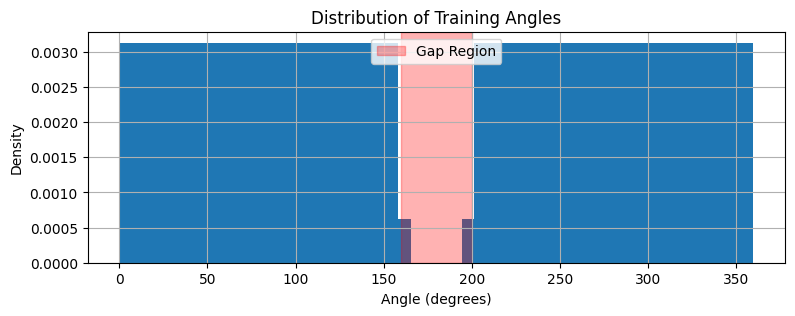

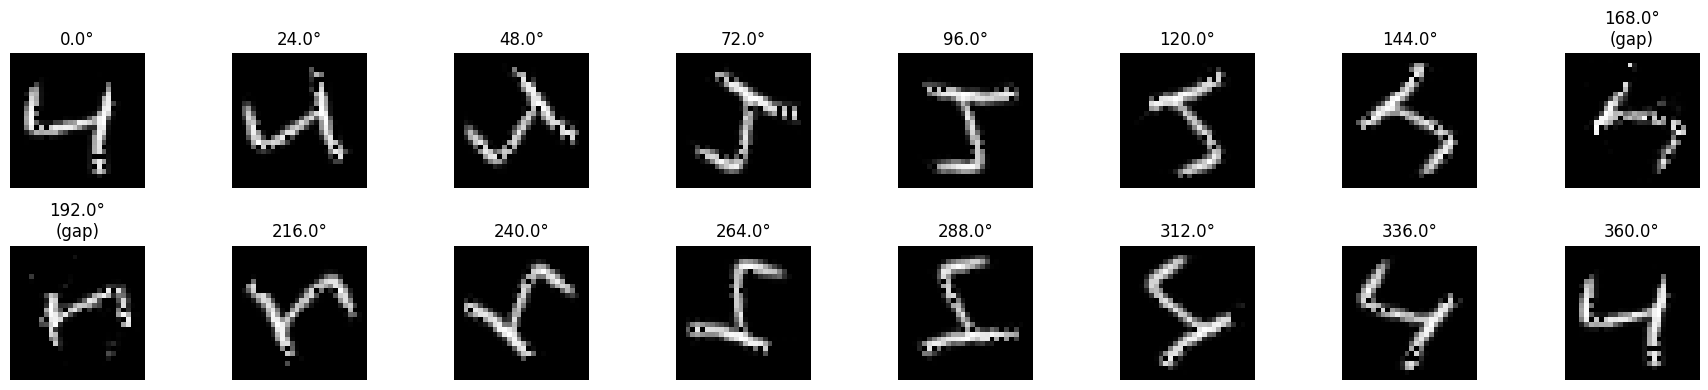

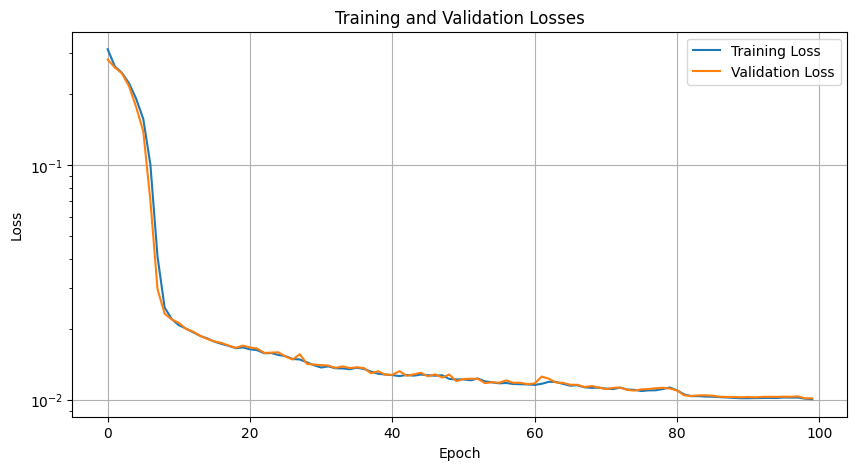

Epoch [101/200]
Training Loss: 0.010053
Validation Loss: 0.010115
Epoch [102/200]
Training Loss: 0.010039
Validation Loss: 0.010115
Epoch [103/200]
Training Loss: 0.010025
Validation Loss: 0.010117
Epoch [104/200]
Training Loss: 0.010024
Validation Loss: 0.010126
Epoch [105/200]
Training Loss: 0.010031
Validation Loss: 0.010134
Epoch [106/200]
Training Loss: 0.010031
Validation Loss: 0.010128
Epoch [107/200]
Training Loss: 0.010023
Validation Loss: 0.010131
Epoch [108/200]
Training Loss: 0.010002
Validation Loss: 0.010068
Epoch [109/200]
Training Loss: 0.009982
Validation Loss: 0.010077
Epoch [110/200]
Training Loss: 0.009972
Validation Loss: 0.010052
Epoch [111/200]
Training Loss: 0.009929
Validation Loss: 0.010039
Epoch [112/200]
Training Loss: 0.009924
Validation Loss: 0.010043
Epoch [113/200]
Training Loss: 0.009929
Validation Loss: 0.010037
Epoch [114/200]
Training Loss: 0.009909
Validation Loss: 0.010045
Epoch [115/200]
Training Loss: 0.009913
Validation Loss: 0.010037
Epoch [116

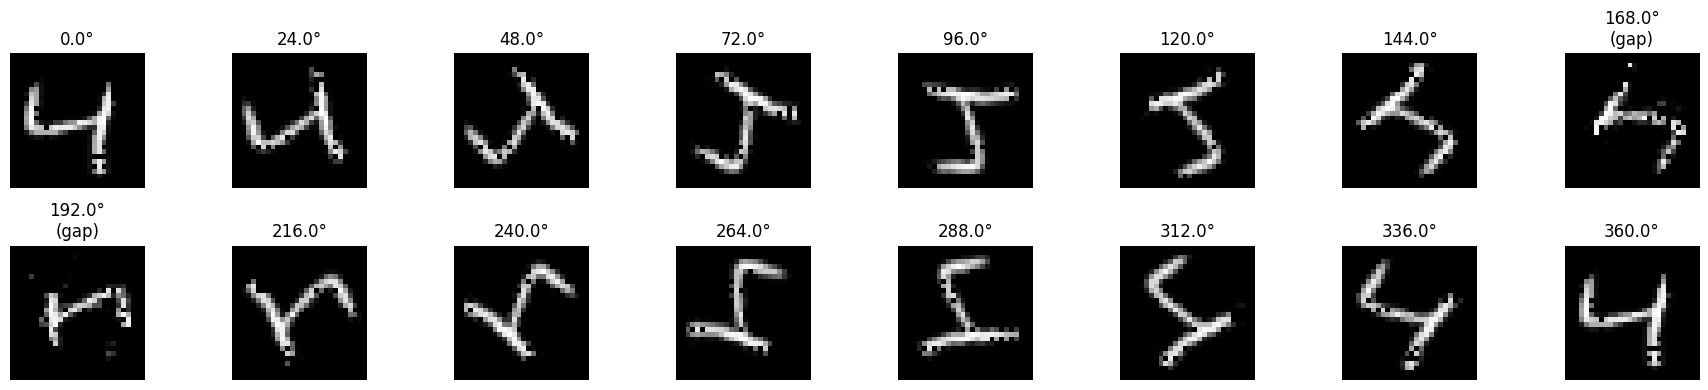

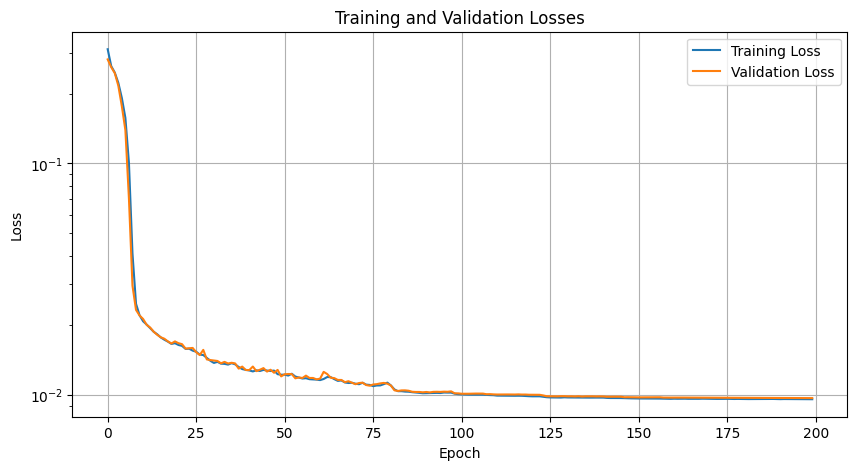

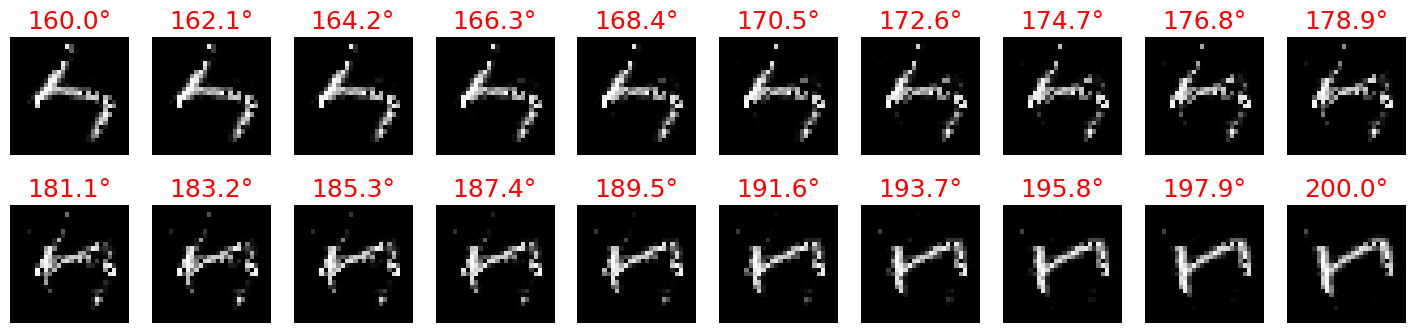

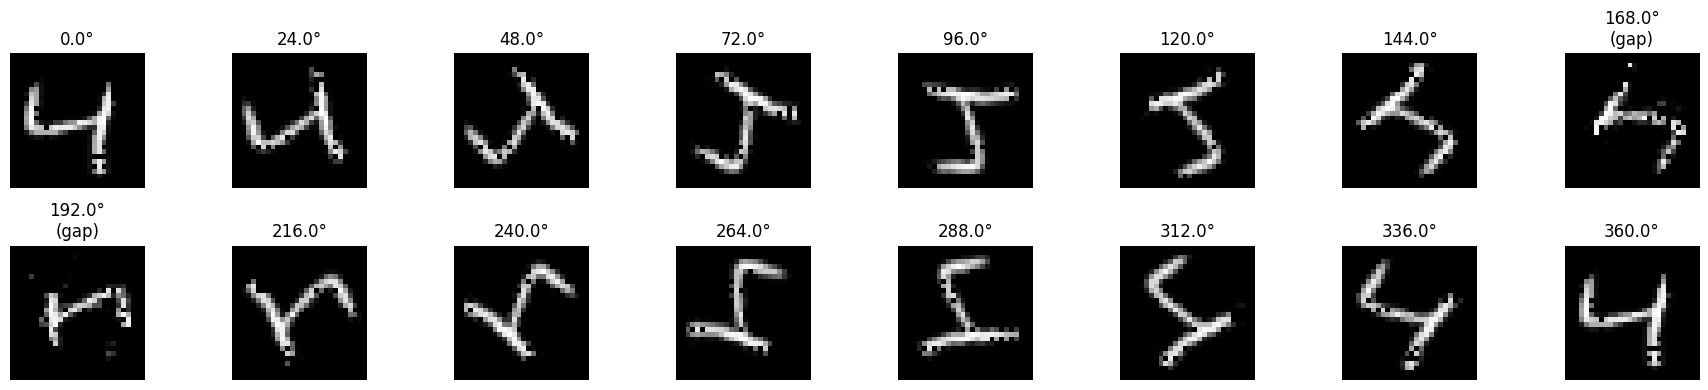

In [6]:
# Create dataset with gap
dataset = RotatedMNISTDataset(num_samples=1000, digit=4, gap_start=160, gap_end=200)

# Visualize the distribution of training angles
visualize_training_distribution(dataset)

# Create and train model
model = CNNDecoderWithActivations(input_size=2, hidden_size=128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training parameters
batch_size = 32
num_epochs = 200
learning_rate = 1e-3

# Train the model
train_losses, val_losses = train_rotation_model(
    model=model,
    train_dataset=dataset,
    batch_size=batch_size,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    visualization_interval=100
)

# Evaluate interpolation in the gap region
evaluate_interpolation(model, device)

# Visualize results across all angles
visualize_results(model, device, num_samples=16, include_gap=True)

/om2/user/qiyao/.conda/envs/umap_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/om2/user/qiyao/.conda/envs/umap_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/om2/user/qiyao/.conda/envs/umap_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/om2/user/qiyao/.conda/envs/umap_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/om2/user/qiyao/.conda/envs/umap_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.

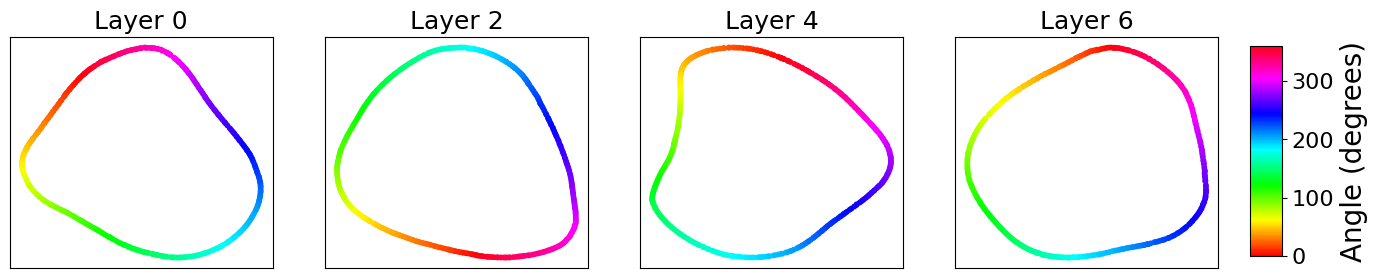

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import umap  # pip install umap-learn

def visualize_activations_all_layers_umap(model, device='cpu'):
    # Larger fonts
    plt.rcParams.update({
        'font.size': 18,
        'axes.labelsize': 20,
        'axes.titlesize': 22,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16
    })

    model.to(device)
    model.eval()

    # Sample 360 angles [0..2π]
    num_samples = 360
    angles = torch.linspace(0, 2*np.pi, num_samples, device=device)
    inputs = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1)

    collected_activations = {}

    def flatten_activation(act):
        return act.view(act.size(0), -1)

    def make_hook(layer_name):
        def hook_fn(module, inp, out):
            collected_activations[layer_name] = out.detach().cpu()
        return hook_fn

    # Register hooks (example: hooking each layer in model.decoder)
    handles = []
    for i, layer in enumerate(model.decoder):
        layer_name = f"layer_{i}"
        h = layer.register_forward_hook(make_hook(layer_name))
        handles.append(h)

    # Forward pass
    with torch.no_grad():
        _ = model(inputs.to(device))

    # Remove hooks
    for h in handles:
        h.remove()

    # Convert angles to degrees
    angles_deg = angles.cpu().numpy() * 180.0 / np.pi

    # Pick every 2nd layer (0,2,4,6,...)
    layer_names = sorted(collected_activations.keys())  # e.g., ['layer_0', 'layer_1', ...]
    layer_indices = list(range(0, len(layer_names), 2))
    layer_subset = [layer_names[i] for i in layer_indices]

    # Subplots in one row, leaving space on the right for colorbar
    fig, axes = plt.subplots(
        1, len(layer_subset),
        figsize=(4 * len(layer_subset), 3),
        gridspec_kw={'right': 0.88},  # squeeze subplots a bit
        sharex=False, sharey=False
    )
    if len(layer_subset) == 1:
        axes = [axes]

    sc_last = None

    for idx, layer_name in enumerate(layer_subset):
        ax = axes[idx]
        act = flatten_activation(collected_activations[layer_name]).numpy()

        # UMAP
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
        embedding = reducer.fit_transform(act)

        # Scatter
        sc = ax.scatter(
            embedding[:, 0], embedding[:, 1],
            c=angles_deg, cmap='hsv', s=10,
            vmin=0, vmax=360
        )
        sc_last = sc
        ax.set_title(f"Layer {layer_indices[idx]}", fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])

    # Dedicated colorbar axis: [x0, y0, width, height] in figure coords
    cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc_last, cax=cbar_ax)
    cbar.set_label("Angle (degrees)", fontsize=20)
    cbar.ax.tick_params(labelsize=16)

    # Optionally tighten layout to avoid overlaps
    plt.tight_layout(rect=[0, 0, 0.88, 1])  # match gridspec_kw 'right' if you like

    # plt.show()
    plt.savefig('../icml_figs/umap_activations_all_layers.pdf', bbox_inches='tight')




visualize_activations_all_layers_umap(model)

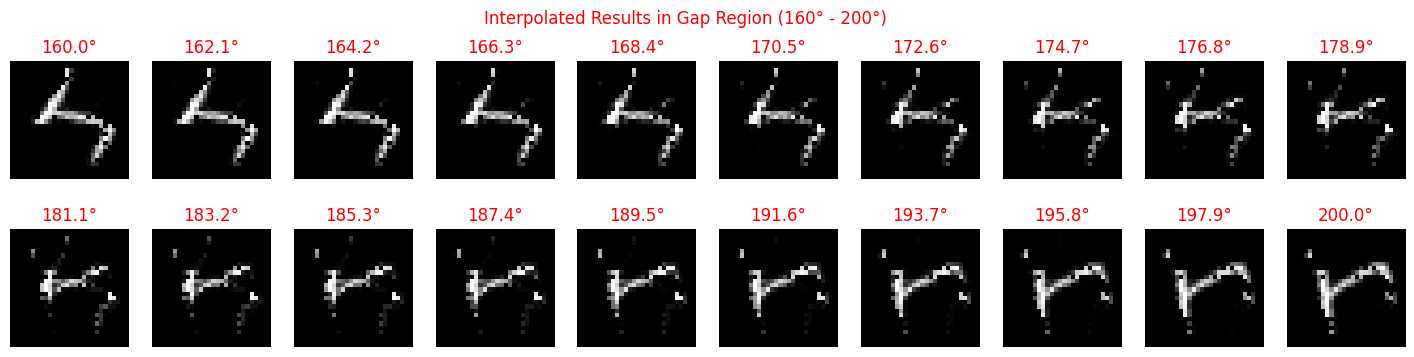

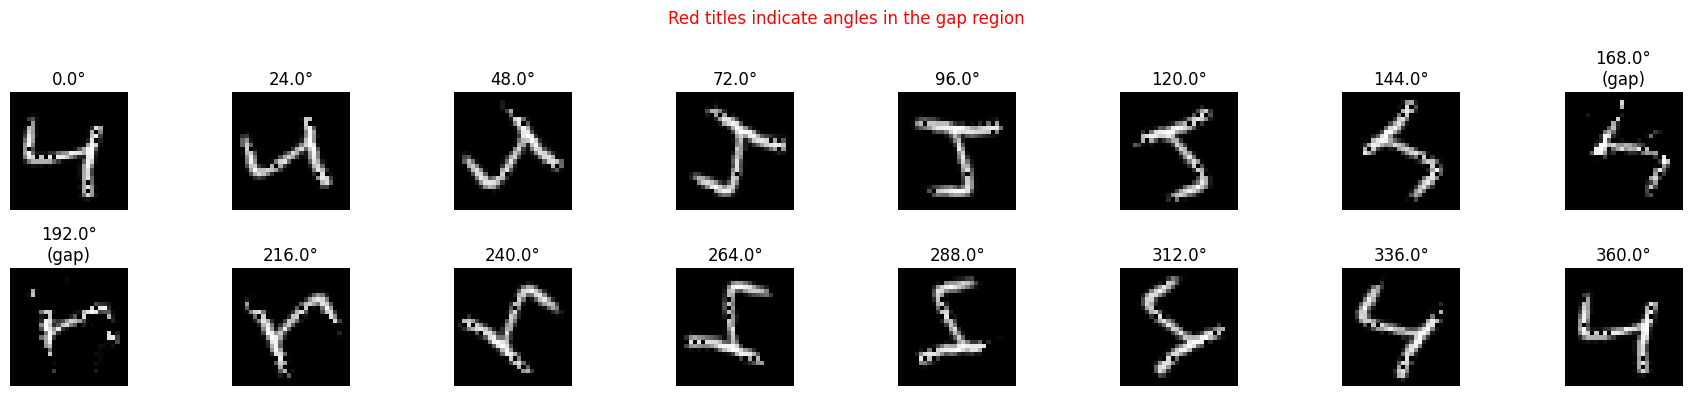

In [6]:
# Evaluate interpolation in the gap region
evaluate_interpolation(model, device)

# Visualize results across all angles
visualize_results(model, device, num_samples=16, include_gap=True)

In [14]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from scipy.ndimage import rotate
# from torchmetrics.functional.image import structural_similarity_index_measure as ssim

def analyze_reconstruction_error(model, device='cuda', num_points=360, gap_start=160, gap_end=200, save_pdf=True, figsize=(7,4)):
    """
    Analyze reconstruction error across all angles, including the gap region.
    
    Args:
        model: The trained model
        device: Computing device
        num_points: Number of angles to evaluate
        gap_start: Start of the gap region in degrees
        gap_end: End of the gap region in degrees
    """
    model.eval()
    
    # Create a dataset with ground truth for all angles (including gap)
    mnist = datasets.MNIST('./data', train=True, download=True,
                          transform=transforms.ToTensor())
    digit_indices = (mnist.targets == 4).nonzero().squeeze()
    original_image = mnist.data[digit_indices[0]].float() / 255.0
    
    # Generate evenly spaced angles
    angles_deg = np.linspace(0, 360, num_points, endpoint=False)
    angles_rad = angles_deg * np.pi / 180
    
    # Compute ground truth and predictions
    mse_errors = []
    ssim_errors = []
    
    with torch.no_grad():
        for angle_deg, angle_rad in zip(angles_deg, angles_rad):
            # Generate ground truth
            rotated = rotate(original_image.numpy(), angle_deg, reshape=False,
                           order=1, mode='constant', cval=0.0)
            ground_truth = torch.tensor(rotated, device=device).unsqueeze(0).unsqueeze(0)
            
            # Generate prediction
            angle_input = torch.tensor([[np.cos(angle_rad), np.sin(angle_rad)]], 
                                     dtype=torch.float32, device=device)
            prediction = model(angle_input)
            
            # Compute MSE error
            mse = F.mse_loss(prediction, ground_truth).item()
            mse_errors.append(mse)
            
            # Compute SSIM error (1 - SSIM)
            ssim_value = ssim(prediction.cpu(), ground_truth.cpu()).item()
            ssim_errors.append(1 - ssim_value)
    
    # Convert to numpy arrays for easier manipulation
    mse_errors = np.array(mse_errors)
    ssim_errors = np.array(ssim_errors)
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Helper function to add gap shading and format axes
    def format_error_plot(ax, angles, errors, title, ylabel):
        ax.plot(angles, errors, '-', linewidth=2)
        ax.axvspan(gap_start, gap_end, color='red', alpha=0.3, label='Out of Distribution')
        
        # Add mean error lines
        in_dist_mask = (angles < gap_start) | (angles > gap_end)
        gap_mask = (angles >= gap_start) & (angles <= gap_end)
        
        in_dist_mean = np.mean(errors[in_dist_mask])
        gap_mean = np.mean(errors[gap_mask])
        
        ax.axhline(y=in_dist_mean, color='blue', linestyle='--', 
                  label=f'In-Distribution Mean: {in_dist_mean:.6f}')
        ax.axhline(y=gap_mean, color='red', linestyle='--',
                  label=f'Gap Mean: {gap_mean:.6f}')
        
        ax.set_xlabel('Rotation Angle (degrees)')
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')
        
        # Set x-axis ticks every 45 degrees
        ax.set_xticks(np.arange(0, 361, 45))
    
    # Plot MSE error
    format_error_plot(ax1, angles_deg, mse_errors,
                     'Reconstruction MSE Error vs. Rotation Angle',
                     'Mean Squared Error')
    
    # Plot SSIM error
    format_error_plot(ax2, angles_deg, ssim_errors,
                     'Reconstruction SSIM Error vs. Rotation Angle',
                     '1 - SSIM (lower is better)')
    
    plt.tight_layout()

    # Optionally save to PDF
    if save_pdf:
        os.makedirs('./icml_figs', exist_ok=True)
        pdf_path = './icml_figs/mse_ssim_plot.pdf'
        plt.savefig(pdf_path, format='pdf', bbox_inches='tight')
        print(f"Figure saved to: {pdf_path}")

    plt.show()
    
    # Print summary statistics
    print("\nError Statistics:")
    print("In Distribution:")
    in_dist_indices = np.where((angles_deg < gap_start) | (angles_deg > gap_end))[0]
    print(f"Mean MSE: {np.mean(mse_errors[in_dist_indices]):.6f}")
    print(f"Std MSE: {np.std(mse_errors[in_dist_indices]):.6f}")
    print(f"Mean SSIM Error: {np.mean(ssim_errors[in_dist_indices]):.6f}")
    print(f"Std SSIM Error: {np.std(ssim_errors[in_dist_indices]):.6f}")
    
    print("\nOut of Distribution (Gap Region):")
    gap_indices = np.where((angles_deg >= gap_start) & (angles_deg <= gap_end))[0]
    print(f"Mean MSE: {np.mean(mse_errors[gap_indices]):.6f}")
    print(f"Std MSE: {np.std(mse_errors[gap_indices]):.6f}")
    print(f"Mean SSIM Error: {np.mean(ssim_errors[gap_indices]):.6f}")
    print(f"Std SSIM Error: {np.std(ssim_errors[gap_indices]):.6f}")
    
    # Return the error arrays and angles for further analysis if needed
    return angles_deg, mse_errors, ssim_errors

import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from scipy.ndimage import rotate

def analyze_reconstruction_error_mse_only(
    model, 
    device='cuda', 
    num_points=360, 
    gap_start=160, 
    gap_end=200, 
    save_pdf=True,
    figsize=(7,4)
):
    """
    Analyze reconstruction error (only MSE) across all angles, including the gap region.
    
    Args:
        model: The trained model
        device: Computing device (e.g., 'cuda' or 'cpu')
        num_points: Number of angles to evaluate (0 to 360)
        gap_start: Start of the gap region in degrees
        gap_end: End of the gap region in degrees
        save_pdf: If True, saves the MSE plot to './icml_figs/mse_plot.pdf'
    """
    model.eval()
    
    # Create a dataset with ground truth for all angles (including gap)
    mnist = datasets.MNIST(
        './data', 
        train=True, 
        download=True,
        transform=transforms.ToTensor()
    )
    digit_indices = (mnist.targets == 4).nonzero().squeeze()
    original_image = mnist.data[digit_indices[0]].float() / 255.0
    
    # Generate evenly spaced angles
    angles_deg = np.linspace(0, 360, num_points, endpoint=False)
    angles_rad = angles_deg * np.pi / 180
    
    # Compute ground truth and predictions
    mse_errors = []
    
    with torch.no_grad():
        for angle_deg, angle_rad in zip(angles_deg, angles_rad):
            # Generate ground truth
            rotated = rotate(
                original_image.numpy(), 
                angle_deg, 
                reshape=False,
                order=1, 
                mode='constant', 
                cval=0.0
            )
            ground_truth = (
                torch.tensor(rotated, dtype=torch.float32, device=device)
                .unsqueeze(0)
                .unsqueeze(0)
            )
            
            # Generate prediction
            angle_input = torch.tensor(
                [[np.cos(angle_rad), np.sin(angle_rad)]], 
                dtype=torch.float32, 
                device=device
            )
            prediction = model(angle_input)
            
            # Compute MSE error
            mse = F.mse_loss(prediction, ground_truth).item()
            mse_errors.append(mse)
    
    # Convert to numpy array
    mse_errors = np.array(mse_errors)
    
    # Create the plot (only one panel for MSE)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Helper function to plot MSE with gap shading
    def format_mse_plot(ax, angles, errors, title, ylabel):
        ax.plot(angles, errors, '-', linewidth=2)
        ax.axvspan(gap_start, gap_end, color='red', alpha=0.3, 
                   label='Out of Distribution')
        
        # Calculate and plot mean lines
        in_dist_mask = (angles < gap_start) | (angles > gap_end)
        gap_mask = (angles >= gap_start) & (angles <= gap_end)
        
        in_dist_mean = np.mean(errors[in_dist_mask])
        gap_mean = np.mean(errors[gap_mask])
        
        ax.axhline(y=in_dist_mean, color='blue', linestyle='--', 
                   label=f'In-Distribution Mean: {in_dist_mean:.6f}')
        ax.axhline(y=gap_mean, color='red', linestyle='--',
                   label=f'Gap Mean: {gap_mean:.6f}')
        
        ax.set_xlabel('Rotation Angle (degrees)')
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')
        # Set x-axis ticks every 45 degrees
        ax.set_xticks(np.arange(0, 361, 45))

    # Plot MSE
    format_mse_plot(
        ax, 
        angles_deg, 
        mse_errors,
        'Reconstruction MSE Error vs. Rotation Angle',
        'Mean Squared Error'
    )
    
    plt.tight_layout()
    
    # Optionally save to PDF
    if save_pdf:
        os.makedirs('./icml_figs', exist_ok=True)
        pdf_path = './icml_figs/mse_plot.pdf'
        plt.savefig(pdf_path, format='pdf', bbox_inches='tight')
        print(f"Figure saved to: {pdf_path}")

    # Show plot
    plt.show()
    
    # Print summary statistics (MSE only)
    print("\nMSE Error Statistics:")
    in_dist_indices = np.where(
        (angles_deg < gap_start) | (angles_deg > gap_end)
    )[0]
    gap_indices = np.where(
        (angles_deg >= gap_start) & (angles_deg <= gap_end)
    )[0]
    
    print("In Distribution:")
    print(f" Mean MSE: {np.mean(mse_errors[in_dist_indices]):.6f}")
    print(f" Std  MSE: {np.std(mse_errors[in_dist_indices]):.6f}")
    
    print("\nOut of Distribution (Gap Region):")
    print(f" Mean MSE: {np.mean(mse_errors[gap_indices]):.6f}")
    print(f" Std  MSE: {np.std(mse_errors[gap_indices]):.6f}")
    
    # Return values if further processing is needed
    return angles_deg, mse_errors

In [15]:
# from torchmetrics.functional.image import structural_similarity_index_measure as ssim
# After training your model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analyze_reconstruction_error_mse_only(
    model, 
    device=device,
    num_points=360,  # One point per degree
    gap_start=160,
    gap_end=200,
    figsize=(6,3)
)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [16]:
# from torchmetrics.functional.image import structural_similarity_index_measure as ssim
# After training your model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analyze_reconstruction_error(
    model, 
    device=device,
    num_points=360,  # One point per degree
    gap_start=160,
    gap_end=200,
    figsize=(7,7)
)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)